In [1]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split, cross_val_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline, FunctionTransformer
import types
import seaborn as sns
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from functools import cache
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.set_printoptions(precision=6, suppress=True)

In [2]:
# pip install scikeras[tensorflow]

In [201]:
    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

@cache
def transform_channel_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def transform_data_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def umap_transform_channel_per_channel(array_name:str,umap):
    array = globals()[array_name]
    transform_list = []
    for channel in range(64):
        transform_list.append(umap.transform(array[:,channel,:]).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list

@cache
def transform_channel_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_channel_per_event(array_name,pca))

@cache
def transform_data_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_data_per_event(array_name,pca))

@cache
def transform_csp(array_name:str,csp):
    array = globals()[array_name]
    return csp.transform(array)

@cache
def concat_channels(array_name:str):
    array = globals()[array_name]
    list_array = []
    for event in array:
        list_array.append(np.concatenate(event))
    return np.vstack(list_array)

@cache
def transform_all_concat(array_name:str,pca):
    return pca.transform(concat_channels(array_name))

@cache
def transform_channel_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event.T)))
    transform_list = np.vstack(transform_list) 
    return transform_list

@cache
def transform_data_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event).T))
    transform_list = np.vstack(transform_list) 
    return transform_list


def create_model(my_params):
    model = tf.keras.Sequential(my_params["layers"])
    model.compile(
        optimizer=my_params["optimizer"],
        loss=my_params["loss"],
        metrics=my_params["metrics"])
    return model

class Pipe:

    def __init__(self,name, model, processed_X_train,processed_X_val, adapter = None):
        self.name = name
        self.model = model
        self.processed_X_train = processed_X_train
        self.processed_X_val = processed_X_val
        if adapter is not None:
            self.adapter = FunctionTransformer(adapter)
        else:
            self.adapter = None
        
    def create_pipeline(self):
        if self.adapter is not None:
            return Pipeline([
                ('adapter', self.adapter),
                ('model', self.model)
            ])
        else:
            return Pipeline([
                ('model', self.model)
            ])


In [4]:
metrics = []
tmin, tmax = -1.0, 4.0
subjects_range = range(1, 110)
files = [4,8,12]
for subject in subjects_range:
    if subject in [88, 92, 100]:
        continue
    for file in files:
        fileName = f'../../downloaded_files/S{subject:03d}R{file:02d}.edf'

        if subject == subjects_range[0] and file == files[0]:
            raw = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
        else:
            new_raw = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
            raw = mne.io.concatenate_raws([raw, new_raw])
            


In [5]:
raw_backup = raw.copy()

In [6]:
raw = raw_backup.copy()

In [7]:
raw.rename_channels({channel:channel.replace(".","") for channel in raw.ch_names})
raw.set_channel_types({channel:"eeg" for channel in raw.ch_names})
# Add positions to channels
mne.datasets.eegbci.standardize(raw)  # set channel names

montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)

raw.annotations.rename(dict(T1="left", T2="right"))
events = mne.events_from_annotations(raw)
# Apply band-pass filter
raw.filter(5.0, 42.0, fir_design="firwin", skip_by_annotation="edge")

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = mne.Epochs(
    raw,
    event_id=[2, 3],
    events = events[0],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)


Used Annotations descriptions: ['T0', 'left', 'right']
Filtering raw data in 318 contiguous segments
Setting up band-pass filter from 5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Not setting metadata
4768 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4768 events and 801 original time points ...
279 bad epochs dropped


In [8]:


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.


epochs_train = epochs.copy().crop(tmin=1.0, tmax=4.0)
labels = epochs.events[:, -1] - 2

In [9]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


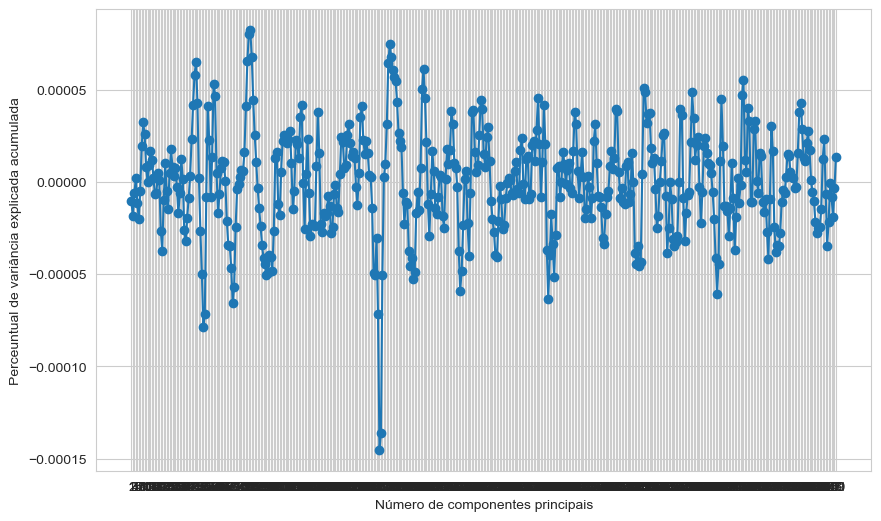

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, 482))
ax.plot(eixo_x, epochs_data_train[0][0], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()

In [11]:
epochs_data_train.shape
# Number of events , channels, each measurement (f*t)

(4489, 64, 481)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(epochs_data_train, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,shuffle = False, random_state=42)


In [ ]:
concat_X_train = concat_channels("X_train")

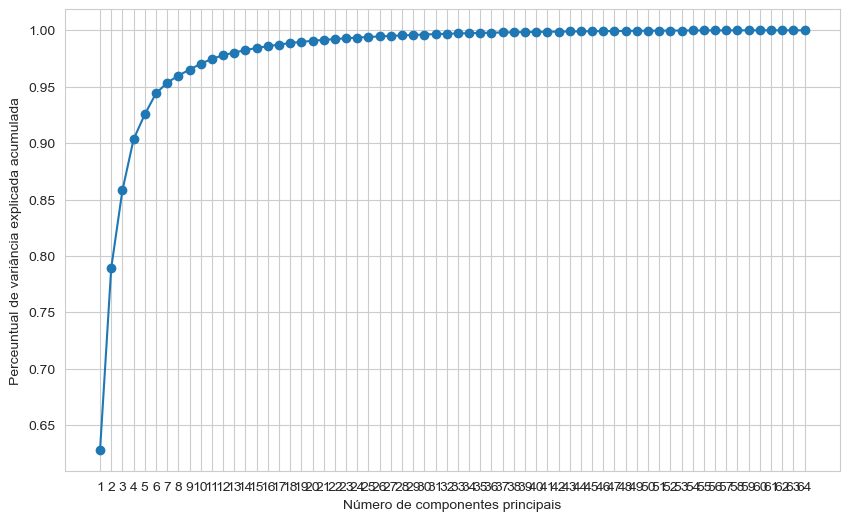

[0.627631 0.789262 0.858047 0.903368 0.925472 0.94401  0.953538 0.959789
 0.965163 0.97029  0.974701 0.977885 0.980324 0.982444 0.984361 0.9859
 0.987365 0.988701 0.989772 0.9907   0.991494 0.992246 0.992952 0.993555
 0.994088 0.994578 0.995042 0.995486 0.995886 0.996269 0.996625 0.996926
 0.997198 0.997445 0.997682 0.997905 0.998089 0.998261 0.998425 0.998584
 0.998729 0.998864 0.998989 0.999106 0.999217 0.999318 0.999412 0.999497
 0.999576 0.999649 0.999705 0.99976  0.999805 0.999845 0.999883 0.999911
 0.999933 0.999952 0.999964 0.999973 0.999981 0.999988 0.999994 1.      ] 0.9778846907903324


In [58]:
pca_channel = PCA(random_state=42,)
for event in X_train:
    pca_channel.fit(event.T)

variancia_explicada_acumulada_channel = np.cumsum(pca_channel.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel,variancia_explicada_acumulada_channel[12-1])

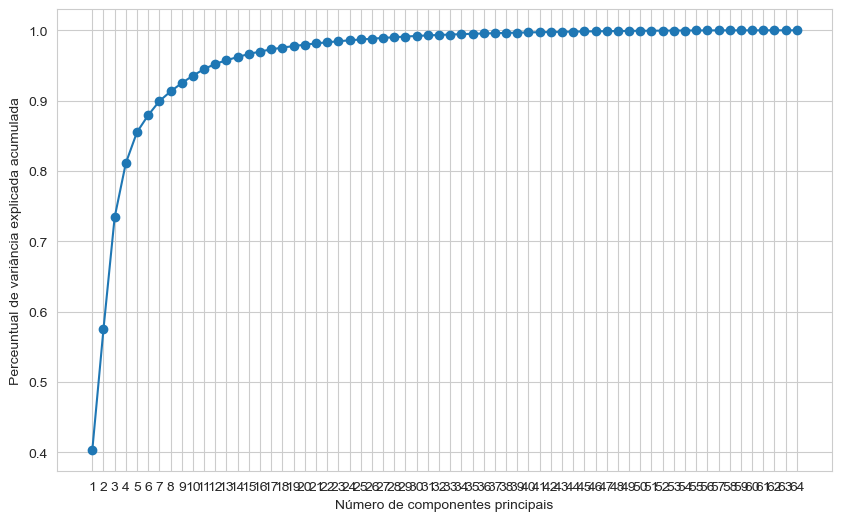

[0.40306  0.575212 0.734281 0.811269 0.855348 0.879381 0.899369 0.913101
 0.925009 0.935568 0.944895 0.952277 0.957487 0.962027 0.966362 0.969818
 0.972938 0.975425 0.977599 0.979526 0.981351 0.98301  0.984416 0.985788
 0.986973 0.988098 0.989175 0.9902   0.991114 0.991989 0.992758 0.993401
 0.993992 0.994547 0.995076 0.995503 0.995904 0.996285 0.996655 0.997011
 0.997336 0.997626 0.997897 0.998156 0.998395 0.998614 0.998816 0.998999
 0.999174 0.999304 0.999432 0.999537 0.999633 0.999724 0.999788 0.999843
 0.999887 0.999916 0.999936 0.999955 0.999972 0.999987 1.       1.      ] 0.9698179210161918


In [14]:
pca_data = PCA(random_state=42,)
for event in X_train:
    pca_data.fit(event)

variancia_explicada_acumulada_data = np.cumsum(pca_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_data,variancia_explicada_acumulada_data[16-1])

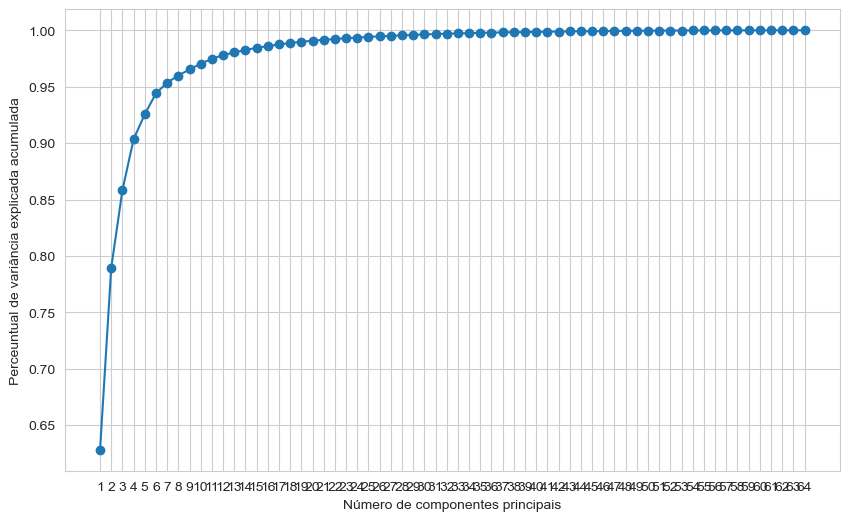

[0.627741 0.789391 0.858192 0.903488 0.925609 0.944113 0.953643 0.959907
 0.965304 0.970407 0.9748   0.97798  0.980421 0.982542 0.984454 0.985998
 0.987458 0.988785 0.989854 0.990781 0.991577 0.992328 0.993028 0.99363
 0.994163 0.994654 0.995118 0.995558 0.995959 0.996338 0.996687 0.996986
 0.997256 0.997504 0.997739 0.997957 0.998141 0.998313 0.998477 0.998633
 0.998777 0.99891  0.999034 0.99915  0.999258 0.999357 0.999449 0.999532
 0.999609 0.999675 0.999732 0.999782 0.999826 0.999865 0.999898 0.999923
 0.999944 0.99996  0.999971 0.99998  0.999987 0.999994 1.       1.      ] 0.9859984527119556


In [15]:
pca_channel_data = PCA(random_state=42,)
for event in transform_channel_per_event("X_train",pca_channel):
    pca_channel_data.fit(event)

variancia_explicada_acumulada_channel_data = np.cumsum(pca_channel_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel_data,variancia_explicada_acumulada_channel_data[16-1])

In [60]:
pca_all = PCA(random_state=42,)

pca_all.fit(concat_X_train)

PCA(random_state=42)

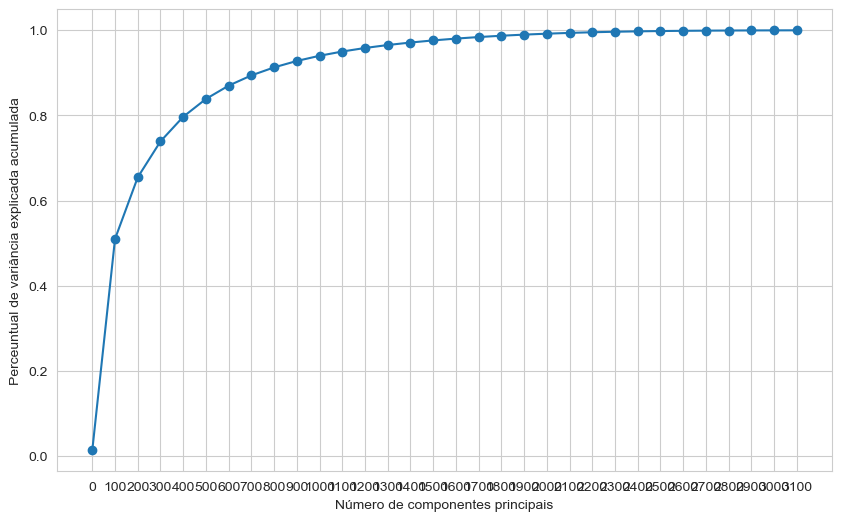

[0.013326 0.025752 0.037461 ... 1.       1.       1.      ] 0.9278469517442862


In [61]:

variancia_explicada_acumulada_all = np.cumsum(pca_all.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(0, len(variancia_explicada_acumulada_all)+1,100))
ax.plot(eixo_x, variancia_explicada_acumulada_all[0::100], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_all,variancia_explicada_acumulada_all[900-1])

In [65]:
del pca_all
del pca_data
del pca_channel_data
del pca_channel


In [66]:
del variancia_explicada_acumulada_all
del variancia_explicada_acumulada_channel
del variancia_explicada_acumulada_channel_data
del variancia_explicada_acumulada_data

In [16]:
pca12_channel = PCA(random_state=42,n_components=12)
for event in X_train:
    pca12_channel.fit(event.T)

In [17]:
pca16_data = PCA(random_state=42,n_components=16)
for event in X_train:
    pca16_data.fit(event)

In [67]:
pca900_all = PCA(random_state=42,n_components=900)
pca900_all.fit(concat_X_train)

PCA(n_components=900, random_state=42)

In [18]:
csp15 = mne.decoding.CSP(n_components=15, reg=None, log=True, norm_trace=False)
csp15.fit(X_train, y_train)


Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 15,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [19]:

csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp4.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0017 (2.2e-16 eps * 64 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [20]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
pca12_channel_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 12 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 12 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [69]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp15 = mne.decoding.CSP(n_components=15, reg=None, log=True, norm_trace=False)
pca12_channel_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 12 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 12 dim * 1.2e+11  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 15,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [21]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp4 = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)
pca16_data_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00092 (2.2e-16 eps * 64 dim * 6.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00092 (2.2e-16 eps * 64 dim * 6.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [70]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp15 = mne.decoding.CSP(n_components=15, reg=None, log=True, norm_trace=False)
pca16_data_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 0.00092 (2.2e-16 eps * 64 dim * 6.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00092 (2.2e-16 eps * 64 dim * 6.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 15,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [22]:
# umap15_unsup = UMAP(n_components=15,random_state=42,n_neighbors=30,min_dist=0.05)
# umap15_unsup.fit(X_train[:,0,:])

In [ ]:
# umap15 = UMAP(n_components=16,random_state=42,n_neighbors=30,min_dist=0.05)
# for channel in range(64):
#     umap15.fit(X_train[:,channel,:],y_train)

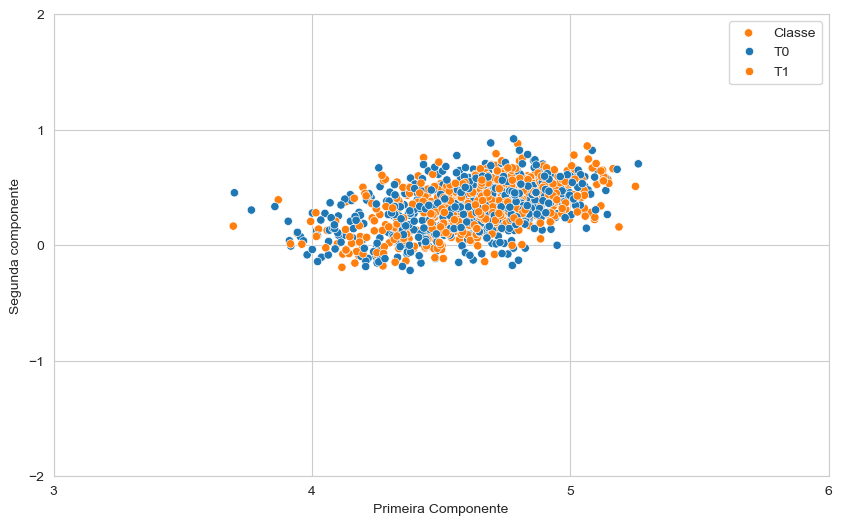

In [118]:
# a = umap15.transform(X_val[:,0,:])
# fig, ax = plt.subplots()
# sns.scatterplot(ax = ax, x = a[:,0],y=  a[:,1], hue =  y_val,palette="tab10")
# ax.set_ylabel("Segunda componente")
# ax.set_xlabel("Primeira Componente")
# ax.legend(["Classe","T0","T1","T2"])
# ax.set_xticks(list(range(3, 6+1))) 
# ax.set_yticks(list(range(-2, 2+1)))
# plt.show()

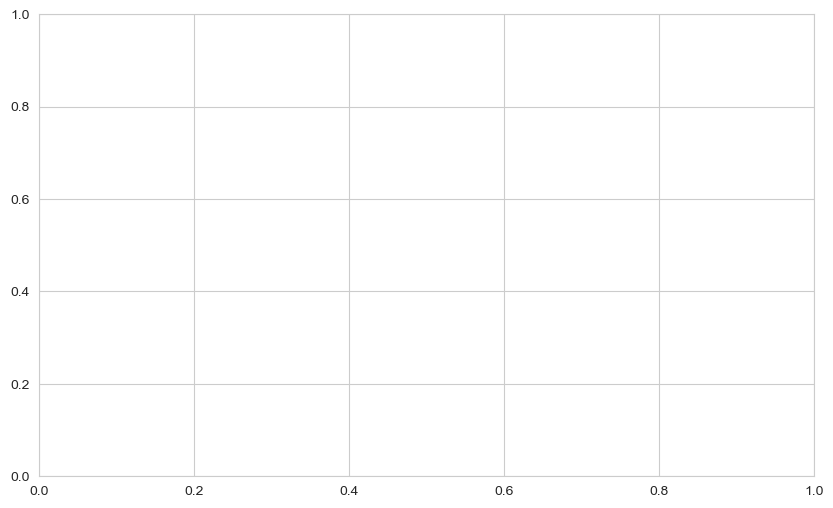

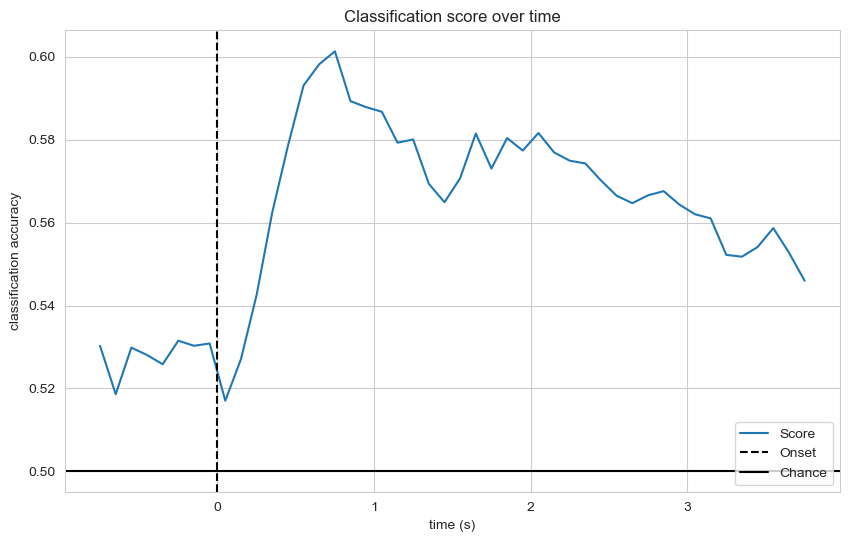

In [164]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
lda = LinearDiscriminantAnalysis()

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp4.transform(epochs_data_train[train_idx])

    # fit classifier
    lda.fit(X_train, y_train)

cv_split = cv.split(epochs_data_train)

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp4.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)


# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [87]:
transform_all_concat("X_train",pca900_all)

(3142, 900)

In [136]:
#Get Indices (it's the same for all, as suffle is False by default)
pipe = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4) )
pipeline = pipe.create_pipeline()
cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True,return_indices=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

print(f"Results for pipeline with {pipe.name}:")
print("----------------")
print("Test accuracy scores:", cv_results['test_Accuracy'])
print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
print("-----")
print("Test F1 scores:", cv_results['test_F1'])
print("Mean test F1:", cv_results['test_F1'].mean())
print("----------------")
print("train accuracy scores:", cv_results['train_Accuracy'])
print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
print("-----")
print("train F1 scores:", cv_results['train_F1'])
print("Mean train F1:", cv_results['train_F1'].mean())
print("----------------")
print("Fit time:", cv_results['fit_time'])
print("Score time:", cv_results['score_time'])
print()
print("--------------------------------------------------------------------------------------------")

indices = cv_results["indices"]["test"]

Results for pipeline with lda_csp4:
----------------
Test accuracy scores: [0.552381 0.533333 0.5      0.550955 0.598726 0.515924 0.528662 0.550955
 0.487261 0.643312]
Mean test accuracy: 0.5461510464058235
-----
Test F1 scores: [0.551495 0.531046 0.492166 0.545306 0.590689 0.476667 0.518325 0.538788
 0.467152 0.632441]
Mean test F1: 0.5344075018978179
----------------
train accuracy scores: [0.551114 0.554298 0.557992 0.550919 0.545262 0.552334 0.557992 0.546322
 0.559052 0.540311]
Mean train accuracy: 0.5515595973160407
-----
train F1 scores: [0.549881 0.553279 0.557482 0.550214 0.544759 0.551526 0.557543 0.545672
 0.558511 0.538644]
Mean train F1: 0.5507510999245134
----------------
Fit time: [0.004976 0.003001 0.003999 0.003002 0.003002 0.003003 0.003001 0.003
 0.003    0.003001]
Score time: [0.004003 0.003001 0.003003 0.002998 0.001998 0.001998 0.002998 0.003002
 0.003    0.002999]

--------------------------------------------------------------------------------------------


In [323]:
# lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),np.abs)
mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),np.abs)
mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),np.abs)
mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),np.abs)
mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),np.abs)
mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),np.abs)
mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),np.abs)
mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),np.abs)
mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),np.abs)
mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),np.abs)
# MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))




Pipes = [
    lda_csp4,
    lda_csp15,
    lda_pca12_channel_csp4,
    lda_pca16_data_csp4,
    lda_pca900_all,
    lda_pca12_channel,
    lda_pca16_data,
    lda_pca12_channel_csp15,
    lda_pca16_data_csp15,
    # mnbc_plain,
    mnbc_csp4,
    mnbc_csp15,
    mnbc_pca12_channel,
    mnbc_pca16_data,
    mnbc_pca900_all,
    mnbc_pca12_channel_csp4,
    mnbc_pca16_data_csp4,
    mnbc_pca12_channel_csp15,
    mnbc_pca16_data_csp15,
    # MLP_plain,
    MLP_csp4,
    MLP_csp15,
    MLP_pca12_channel,
    MLP_pca16_data,
    MLP_pca900_all,
    MLP_pca12_channel_csp4,
    MLP_pca16_data_csp4,
    MLP_pca12_channel_csp15,
    MLP_pca16_data_csp15,
    Keras_MLP_csp4,
    Keras_MLP_csp15,
    Keras_MLP_pca12_channel,
    Keras_MLP_pca16_data,
    Keras_MLP_pca900_all,
    Keras_MLP_pca16_data_csp4,
    Keras_MLP_pca12_channel_csp4,
    Keras_MLP_pca16_data_csp15,
    Keras_MLP_pca12_channel_csp15,
    
    
    
]


In [324]:
results = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", cv_results['test_Accuracy'])
    print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
    print("-----")
    print("Test F1 scores:", cv_results['test_F1'])
    print("Mean test F1:", cv_results['test_F1'].mean())
    print("----------------")
    print("train accuracy scores:", cv_results['train_Accuracy'])
    print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
    print("-----")
    print("train F1 scores:", cv_results['train_F1'])
    print("Mean train F1:", cv_results['train_F1'].mean())
    print("----------------")
    print("Fit time:", cv_results['fit_time'])
    print("Score time:", cv_results['score_time'])
    print()
    print("--------------------------------------------------------------------------------------------")

    results[pipe.name] = (cv_results)

lda_csp4
Results for pipeline with lda_csp4:
----------------
Test accuracy scores: [0.552381 0.533333 0.5      0.550955 0.598726 0.515924 0.528662 0.550955
 0.487261 0.643312]
Mean test accuracy: 0.5461510464058235
-----
Test F1 scores: [0.551495 0.531046 0.492166 0.545306 0.590689 0.476667 0.518325 0.538788
 0.467152 0.632441]
Mean test F1: 0.5344075018978179
----------------
train accuracy scores: [0.551114 0.554298 0.557992 0.550919 0.545262 0.552334 0.557992 0.546322
 0.559052 0.540311]
Mean train accuracy: 0.5515595973160407
-----
train F1 scores: [0.549881 0.553279 0.557482 0.550214 0.544759 0.551526 0.557543 0.545672
 0.558511 0.538644]
Mean train F1: 0.5507510999245134
----------------
Fit time: [0.005    0.003    0.003001 0.003002 0.003    0.002998 0.003002 0.003
 0.003    0.002999]
Score time: [0.002999 0.001998 0.002999 0.001997 0.002003 0.003    0.001997 0.001999
 0.002001 0.003001]

------------------------------------------------------------------------------------------

In [325]:
for key, value in results.items(): 
    print(value['test_Accuracy'])
    print(",")

[0.552381 0.533333 0.5      0.550955 0.598726 0.515924 0.528662 0.550955
 0.487261 0.643312]
,
[0.596825 0.574603 0.522293 0.605096 0.671975 0.601911 0.570064 0.595541
 0.640127 0.646497]
,
[0.596825 0.526984 0.538217 0.601911 0.624204 0.557325 0.636943 0.579618
 0.585987 0.557325]
,
[0.552381 0.565079 0.56051  0.611465 0.582803 0.627389 0.535032 0.55414
 0.611465 0.636943]
,
[0.488889 0.520635 0.515924 0.5      0.461783 0.458599 0.503185 0.480892
 0.506369 0.506369]
,
[0.514286 0.485714 0.522293 0.464968 0.531847 0.480892 0.490446 0.484076
 0.490446 0.436306]
,
[0.495238 0.501587 0.538217 0.433121 0.471338 0.515924 0.458599 0.5
 0.44586  0.503185]
,
[0.593651 0.533333 0.570064 0.576433 0.633758 0.547771 0.621019 0.601911
 0.585987 0.570064]
,
[0.574603 0.596825 0.563694 0.649682 0.624204 0.681529 0.566879 0.630573
 0.633758 0.656051]
,
[0.530159 0.511111 0.487261 0.570064 0.570064 0.528662 0.528662 0.512739
 0.519108 0.636943]
,
[0.530159 0.51746  0.528662 0.557325 0.601911 0.547771 0

In [326]:
for key, value in results.items(): 
    print(np.mean(value['test_Accuracy']))
    print(",")

0.5461510464058235
,
0.6024931756141947
,
0.5805338186229906
,
0.5837205540390253
,
0.49426448286320906
,
0.4901273885350319
,
0.4863067435041957
,
0.5833990496410879
,
0.6177797998180163
,
0.5394773025983217
,
0.5407491659084016
,
0.5012728743301992
,
0.5012728743301992
,
0.5012728743301992
,
0.5515610150641997
,
0.5620796683854008
,
0.545839652209079
,
0.562706500859367
,
0.507323829744212
,
0.5493114952987563
,
0.5003184713375797
,
0.49968051764230115
,
0.5000010110201194
,
0.5028672530583359
,
0.5315195632393085
,
0.5063633606308766
,
0.5544414113840865
,
0.5544444444444443
,
0.6018592659993934
,
0.4999989889798807
,
0.4999989889798807
,
0.4999989889798807
,
0.576715195632393
,
0.5894469719947427
,
0.6247952684258415
,
0.5776807198463249
,


In [327]:
for key, value in results.items(): 
    print(np.max(value['test_Accuracy']))
    print(",")

0.643312101910828
,
0.6719745222929936
,
0.6369426751592356
,
0.6369426751592356
,
0.5206349206349207
,
0.5318471337579618
,
0.5382165605095541
,
0.6337579617834395
,
0.6815286624203821
,
0.6369426751592356
,
0.6019108280254777
,
0.5031847133757962
,
0.5031847133757962
,
0.5031847133757962
,
0.5923566878980892
,
0.6528662420382165
,
0.6210191082802548
,
0.6050955414012739
,
0.5318471337579618
,
0.5873015873015873
,
0.5031847133757962
,
0.5031847133757962
,
0.5031847133757962
,
0.5636942675159236
,
0.5828025477707006
,
0.5477707006369427
,
0.6273885350318471
,
0.6210191082802548
,
0.7038216560509554
,
0.5031847133757962
,
0.5031847133757962
,
0.5031847133757962
,
0.6210191082802548
,
0.6496815286624203
,
0.6847133757961783
,
0.6401273885350318
,


In [328]:
for key, value in results.items(): 
    print(value['test_F1'])
    print(",")

[0.551495 0.531046 0.492166 0.545306 0.590689 0.476667 0.518325 0.538788
 0.467152 0.632441]
,
[0.595505 0.573361 0.452657 0.600411 0.671411 0.598486 0.570024 0.594055
 0.640036 0.640365]
,
[0.596027 0.526048 0.537987 0.601713 0.624189 0.551092 0.630329 0.570398
 0.58592  0.556023]
,
[0.552381 0.557207 0.557475 0.610454 0.570568 0.626536 0.533499 0.551941
 0.611071 0.636412]
,
[0.488868 0.519686 0.513952 0.499141 0.461122 0.457807 0.503165 0.480465
 0.504918 0.506364]
,
[0.514266 0.485709 0.522293 0.463204 0.531462 0.480886 0.489431 0.482733
 0.490115 0.436163]
,
[0.494729 0.501587 0.538212 0.432753 0.471144 0.515904 0.458247 0.499751
 0.445049 0.503003]
,
[0.59345  0.533164 0.570059 0.575913 0.633754 0.54628  0.614446 0.591975
 0.585382 0.56908 ]
,
[0.567272 0.580577 0.562412 0.647953 0.619745 0.681412 0.559734 0.62619
 0.630153 0.656051]
,
[0.529775 0.509683 0.486381 0.569535 0.566365 0.515371 0.514298 0.510948
 0.511574 0.621206]
,
[0.528786 0.513336 0.523071 0.544343 0.568809 0.547

In [329]:
for key, value in results.items(): 
    print(value['train_Accuracy'])
    print(",")

[0.551114 0.554298 0.557992 0.550919 0.545262 0.552334 0.557992 0.546322
 0.559052 0.540311]
,
[0.605589 0.610541 0.614215 0.610679 0.606082 0.610325 0.619165 0.61174
 0.615983 0.60396 ]
,
[0.584365 0.594977 0.58628  0.585573 0.580976 0.590523 0.58239  0.582037
 0.583098 0.585573]
,
[0.584011 0.581535 0.587694 0.578854 0.579562 0.579562 0.589109 0.585573
 0.578501 0.576025]
,
[0.724797 0.721967 0.725248 0.727369 0.725248 0.726662 0.723833 0.723479
 0.733027 0.727016]
,
[0.97913  0.978422 0.975955 0.978784 0.979491 0.980905 0.976308 0.978076
 0.98232  0.983734]
,
[0.756279 0.756632 0.750707 0.764851 0.755658 0.758487 0.760608 0.756011
 0.762376 0.756365]
,
[0.586487 0.598161 0.592291 0.587694 0.585219 0.595827 0.589463 0.588402
 0.587694 0.592645]
,
[0.629643 0.629996 0.636139 0.62058  0.621994 0.621287 0.629774 0.622348
 0.618812 0.621641]
,
[0.54404  0.547931 0.548444 0.53819  0.53819  0.546676 0.542079 0.541018
 0.54314  0.531471]
,
[0.548638 0.548638 0.548444 0.546676 0.540665 0.544

In [330]:
for key, value in results.items(): 
    print(np.mean(value['train_Accuracy']))
    print(",")

0.5515595973160407
,
0.610828010260726
,
0.5855791846555418
,
0.5820426289432723
,
0.725864454149695
,
0.9793125018449593
,
0.7577974862522383
,
0.5903884246123334
,
0.6252213450917077
,
0.5421178207314894
,
0.5480586024138823
,
0.5012730719986952
,
0.5012730719986952
,
0.5012730719986952
,
0.5526558534119115
,
0.5593396471386994
,
0.5491903317624702
,
0.5702315868051506
,
0.5573197480948762
,
0.6895535648617669
,
0.5000707213578501
,
0.5008487438515947
,
0.4991512561484052
,
0.5391441840126202
,
0.5892905549587756
,
0.5640143113811102
,
0.6874962162697649
,
0.5657051697387638
,
0.6193509095211911
,
0.5008487438515947
,
0.5008487438515947
,
0.5008487438515947
,
0.5850132636943517
,
0.5913079398545745
,
0.6441760448974303
,
0.5883727158152169
,


In [331]:
for key, value in results.items(): 
    print(np.max(value['train_Accuracy']))
    print(",")

0.559052333804809
,
0.6191654879773691
,
0.5949770074283693
,
0.5891089108910891
,
0.733026874115983
,
0.9837340876944838
,
0.7648514851485149
,
0.5981605942695437
,
0.6361386138613861
,
0.5484441301272984
,
0.556930693069307
,
0.5014144271570015
,
0.5014144271570015
,
0.5014144271570015
,
0.5583451202263083
,
0.5671852899575672
,
0.5551626591230552
,
0.5772904138662893
,
0.669024045261669
,
0.8437057991513437
,
0.5045968882602546
,
0.5074257425742574
,
0.501060820367751
,
0.7153465346534653
,
0.696958981612447
,
0.8234877962504422
,
0.940947666195191
,
0.5735502121640735
,
0.6262376237623762
,
0.5014144271570015
,
0.5014144271570015
,
0.5014144271570015
,
0.5951202263083452
,
0.5963919349133356
,
0.6494517155995755
,
0.5915841584158416
,


In [332]:
for key, value in results.items(): 
    print(value['train_F1'])
    print(",")

[0.549881 0.553279 0.557482 0.550214 0.544759 0.551526 0.557543 0.545672
 0.558511 0.538644]
,
[0.605576 0.610529 0.614189 0.610571 0.606062 0.610318 0.619162 0.611707
 0.61596  0.603896]
,
[0.584355 0.594918 0.586275 0.585556 0.580973 0.590518 0.58239  0.581996
 0.583091 0.585573]
,
[0.584    0.581533 0.587694 0.578854 0.579559 0.579557 0.589079 0.585563
 0.578493 0.576021]
,
[0.724768 0.721963 0.725238 0.727368 0.725247 0.72661  0.723823 0.723471
 0.732999 0.727012]
,
[0.97913  0.978422 0.975955 0.978784 0.979491 0.980905 0.976308 0.978076
 0.98232  0.983734]
,
[0.756278 0.756632 0.75066  0.764839 0.755654 0.758481 0.760607 0.756005
 0.762374 0.756362]
,
[0.586484 0.598099 0.592269 0.587665 0.585208 0.595821 0.589435 0.588367
 0.58767  0.592644]
,
[0.629636 0.629993 0.635991 0.62058  0.621994 0.621287 0.629774 0.622347
 0.618812 0.621629]
,
[0.54382  0.547861 0.548358 0.538171 0.538123 0.546665 0.542049 0.540632
 0.543029 0.531105]
,
[0.548603 0.548414 0.54822  0.546414 0.540391 0.54

In [333]:
for key, value in results.items(): 
    print(value['fit_time'])
    print(",")

[0.005    0.003    0.003001 0.003002 0.003    0.002998 0.003002 0.003
 0.003    0.002999]
,
[0.011002 0.018002 0.011001 0.007999 0.007002 0.009    0.008    0.008
 0.007001 0.006998]
,
[0.003998 0.003    0.002999 0.003003 0.003001 0.003001 0.003004 0.002999
 0.003001 0.003   ]
,
[0.002999 0.003002 0.002997 0.003    0.003001 0.004998 0.003002 0.002996
 0.002999 0.003003]
,
[0.555999 0.526    0.502996 0.837998 0.525001 0.500992 0.522999 0.508
 0.529    0.516997]
,
[17.631    17.295998 17.079999 17.117999 17.214002 17.576001 17.524
 17.424    17.415    17.413002]
,
[0.72     0.950001 0.710002 0.711998 0.682    0.710998 0.713999 0.684
 0.703002 0.707001]
,
[0.007    0.006001 0.006001 0.005    0.004999 0.005    0.006007 0.006001
 0.005    0.005   ]
,
[0.007002 0.006    0.006001 0.006002 0.006999 0.005999 0.006    0.004998
 0.006    0.008   ]
,
[0.001999 0.002001 0.002003 0.002    0.002    0.002001 0.002002 0.002001
 0.001    0.001001]
,
[0.003001 0.002    0.002    0.002002 0.002    0.001998 

In [334]:
for key, value in results.items(): 
    print(value['score_time'])
    print(",")

[0.002999 0.001998 0.002999 0.001997 0.002003 0.003    0.001997 0.001999
 0.002001 0.003001]
,
[0.002999 0.004999 0.002999 0.002999 0.003    0.003    0.003998 0.003
 0.001999 0.003001]
,
[0.002002 0.002999 0.003003 0.002998 0.002998 0.002001 0.002996 0.003
 0.003001 0.001998]
,
[0.003002 0.001998 0.002002 0.003001 0.002999 0.002999 0.002998 0.002001
 0.003    0.002999]
,
[0.004002 0.002999 0.003    0.003002 0.002999 0.003001 0.003    0.003002
 0.002    0.003002]
,
[0.006003 0.006001 0.006    0.007001 0.005    0.006001 0.005001 0.005999
 0.006002 0.005997]
,
[0.003    0.003    0.004009 0.004001 0.003    0.002999 0.003999 0.004001
 0.002998 0.003   ]
,
[0.002    0.001998 0.002    0.003001 0.002001 0.003    0.001993 0.001998
 0.003001 0.002999]
,
[0.003    0.002001 0.003    0.001998 0.002999 0.002999 0.004002 0.003001
 0.004    0.004   ]
,
[0.002003 0.003001 0.002999 0.002998 0.001999 0.003    0.001998 0.002999
 0.002001 0.003   ]
,
[0.002    0.002    0.002    0.002999 0.003001 0.002002 0

- Todos os modelos que receberam apenas PCA não foram capaz de apresentar uma acurária significativamente maior que chance level.
- O melhor modelo em todas as configurações foi a junção do PCA_data com CSP15
- Em todos os modelos, a segunda maior média pertence ao modelo CSP15 ou PCA_data com CSP4
- O melhor modelo foi o LDA, seguido pelo Keras

In [335]:
f = []
for key, value in results.items(): 
    f.append(value['train_Accuracy'])

np.mean(np.array(f), axis=0)

array([0.575787, 0.601285, 0.57742 , 0.584453, 0.586506, 0.591653,
       0.58242 , 0.591064, 0.567529, 0.591152])

In [336]:
f = []
for key, value in results.items(): 
    f.append(value['test_Accuracy'])

np.mean(np.array(f), axis=0)

array([0.533333, 0.527513, 0.526805, 0.546886, 0.559448, 0.546178,
       0.525655, 0.535474, 0.541755, 0.564667])

Podemos notar que a última separação de treino e teste teve um resultado notavelmente maior que os demais, enquanto as separações 2,3,7,8 foram as piores.

In [337]:
X_train[indices[9]].shape

(314, 64, 481)

In [338]:
np.floor(np.sqrt(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1]+3))

3.0

lda_csp4
Results for pipeline with lda_csp4:
----------------
Test accuracy scores: 0.5352635486265775
----------------
train accuracy scores: 0.5528325907065563

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5404    0.4763    0.5063       674
           1     0.5312    0.5944    0.5610       673

    accuracy                         0.5353      1347
   macro avg     0.5358    0.5353    0.5337      1347
weighted avg     0.5358    0.5353    0.5336      1347



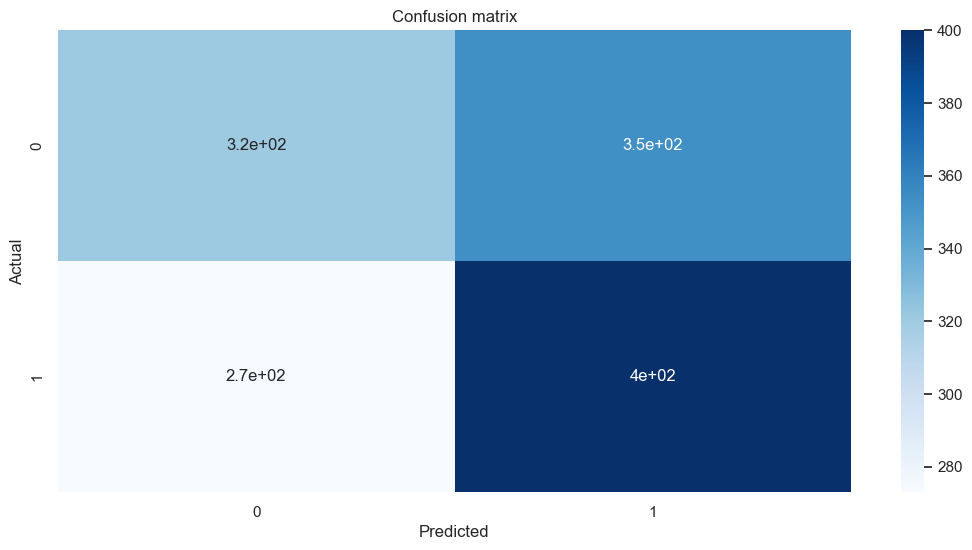

lda_csp15
Results for pipeline with lda_csp15:
----------------
Test accuracy scores: 0.5597624350408315
----------------
train accuracy scores: 0.6107574793125398

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5661    0.5148    0.5392       674
           1     0.5545    0.6048    0.5785       673

    accuracy                         0.5598      1347
   macro avg     0.5603    0.5598    0.5589      1347
weighted avg     0.5603    0.5598    0.5589      1347



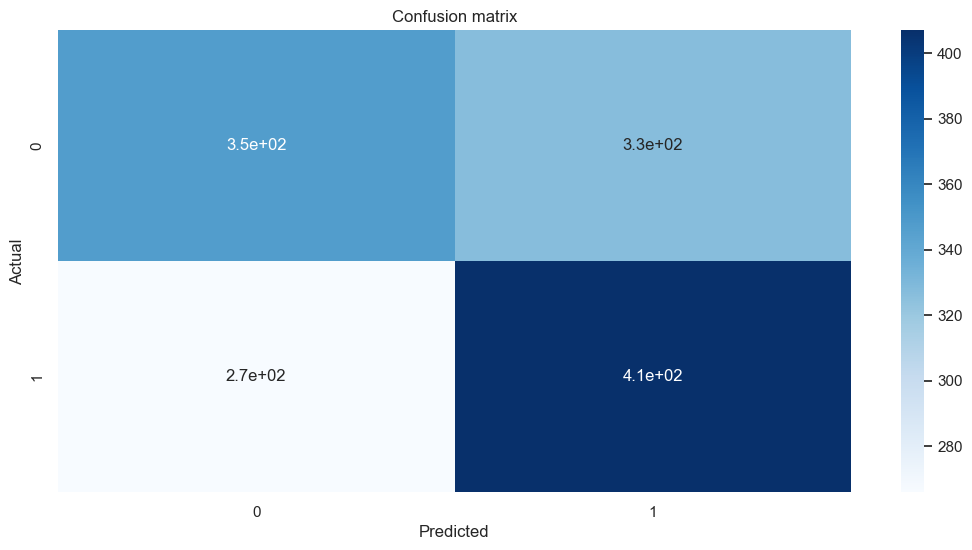

lda_pca12_channel_csp4
Results for pipeline with lda_pca12_channel_csp4:
----------------
Test accuracy scores: 0.5805493689680772
----------------
train accuracy scores: 0.5856142584341184

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5889    0.5356    0.5610       674
           1     0.5736    0.6256    0.5984       673

    accuracy                         0.5805      1347
   macro avg     0.5812    0.5806    0.5797      1347
weighted avg     0.5812    0.5805    0.5797      1347



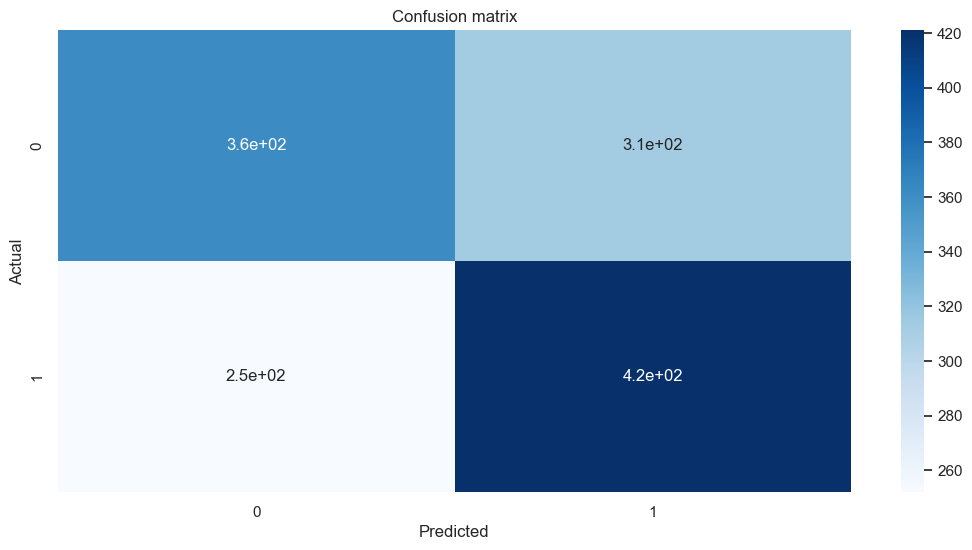

lda_pca16_data_csp4
Results for pipeline with lda_pca16_data_csp4:
----------------
Test accuracy scores: 0.5285820341499629
----------------
train accuracy scores: 0.5852959898154042

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5321    0.4792    0.5043       674
           1     0.5257    0.5780    0.5506       673

    accuracy                         0.5286      1347
   macro avg     0.5289    0.5286    0.5274      1347
weighted avg     0.5289    0.5286    0.5274      1347



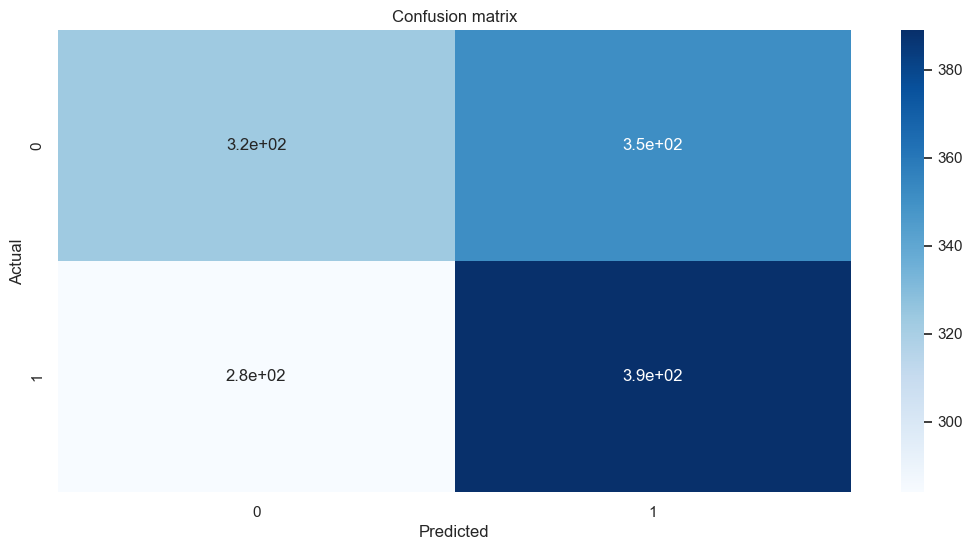

lda_pca900_all
Results for pipeline with lda_pca900_all:
----------------
Test accuracy scores: 0.5092798812175204
----------------
train accuracy scores: 0.7119669000636537

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5101    0.4852    0.4973       674
           1     0.5085    0.5334    0.5207       673

    accuracy                         0.5093      1347
   macro avg     0.5093    0.5093    0.5090      1347
weighted avg     0.5093    0.5093    0.5090      1347



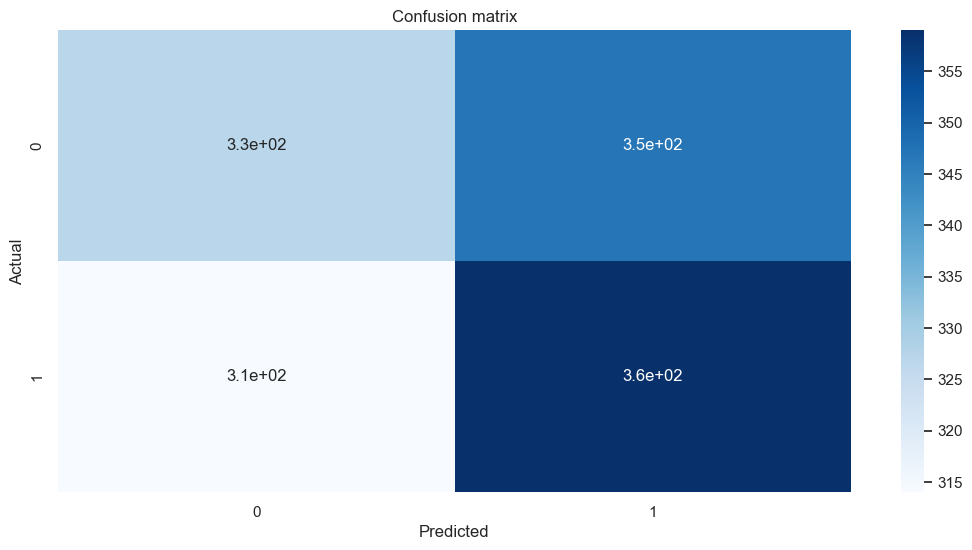

lda_pca12_channel
Results for pipeline with lda_pca12_channel:
----------------
Test accuracy scores: 0.5196733481811433
----------------
train accuracy scores: 0.9904519414385742

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5196    0.5312    0.5253       674
           1     0.5198    0.5082    0.5139       673

    accuracy                         0.5197      1347
   macro avg     0.5197    0.5197    0.5196      1347
weighted avg     0.5197    0.5197    0.5196      1347



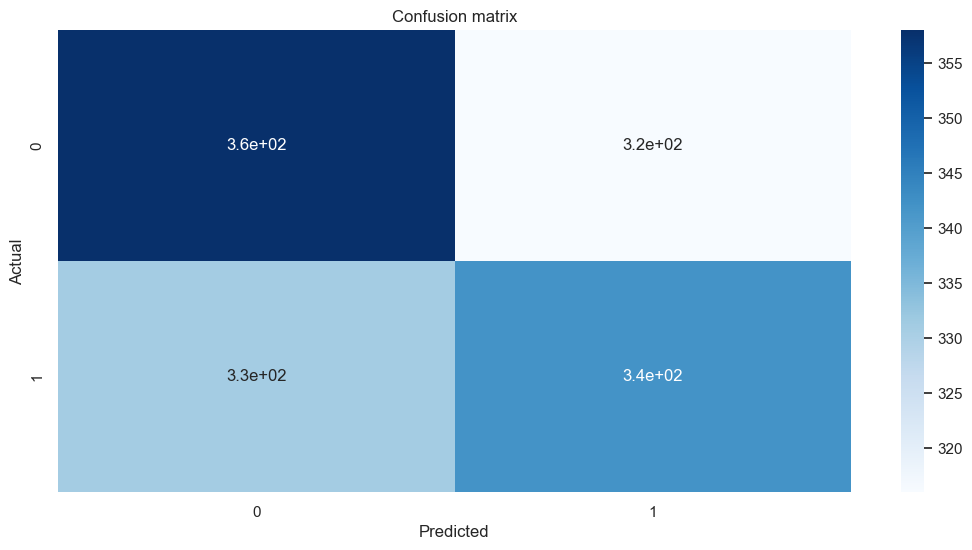

lda_pca16_data
Results for pipeline with lda_pca16_data:
----------------
Test accuracy scores: 0.5159613956941351
----------------
train accuracy scores: 0.7377466581795035

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5158    0.5326    0.5241       674
           1     0.5161    0.4993    0.5076       673

    accuracy                         0.5160      1347
   macro avg     0.5160    0.5159    0.5158      1347
weighted avg     0.5160    0.5160    0.5158      1347



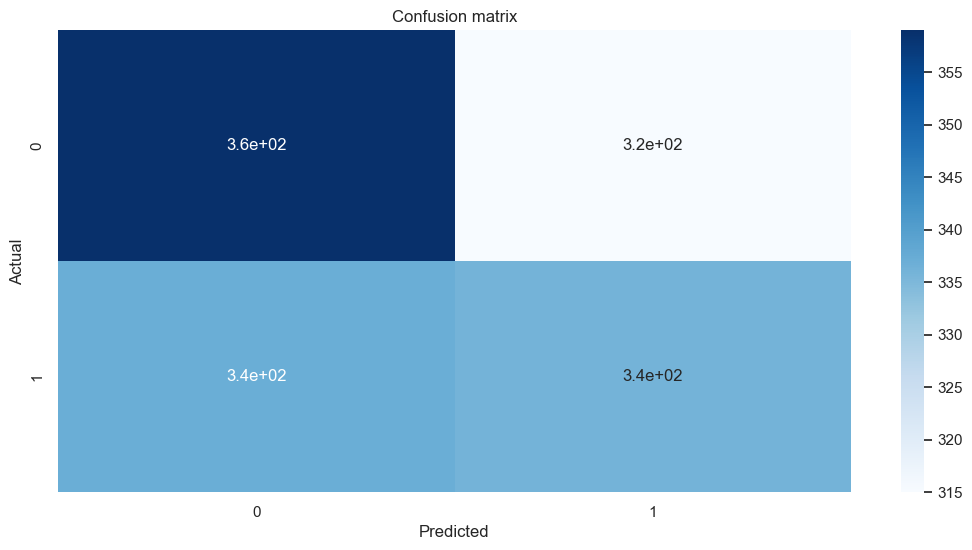

lda_pca12_channel_csp15
Results for pipeline with lda_pca12_channel_csp15:
----------------
Test accuracy scores: 0.5671863400148478
----------------
train accuracy scores: 0.5900700190961171

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5705    0.5460    0.5580       674
           1     0.5641    0.5884    0.5760       673

    accuracy                         0.5672      1347
   macro avg     0.5673    0.5672    0.5670      1347
weighted avg     0.5673    0.5672    0.5670      1347



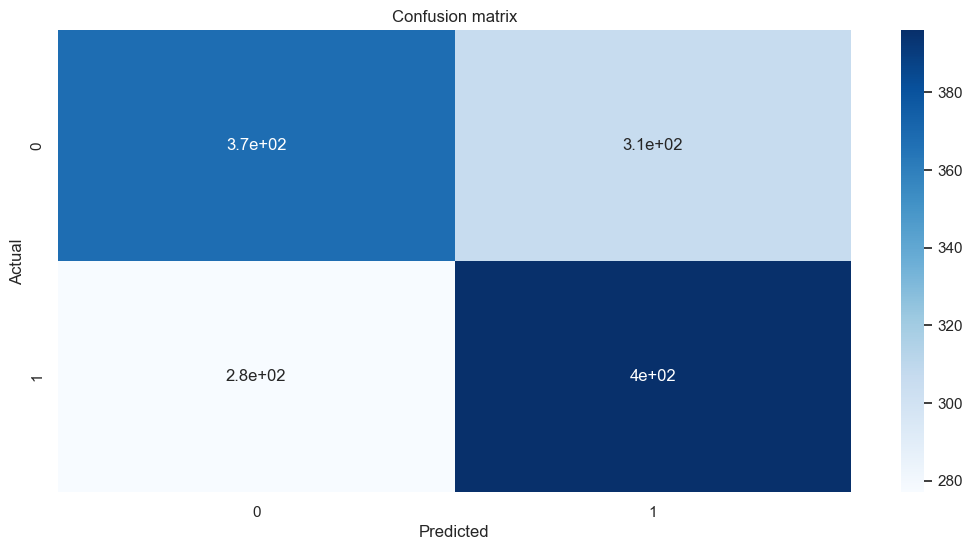

lda_pca16_data_csp15
Results for pipeline with lda_pca16_data_csp15:
----------------
Test accuracy scores: 0.5382331106161841
----------------
train accuracy scores: 0.6260343730108211

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5394    0.5282    0.5337       674
           1     0.5371    0.5483    0.5426       673

    accuracy                         0.5382      1347
   macro avg     0.5383    0.5382    0.5382      1347
weighted avg     0.5383    0.5382    0.5382      1347



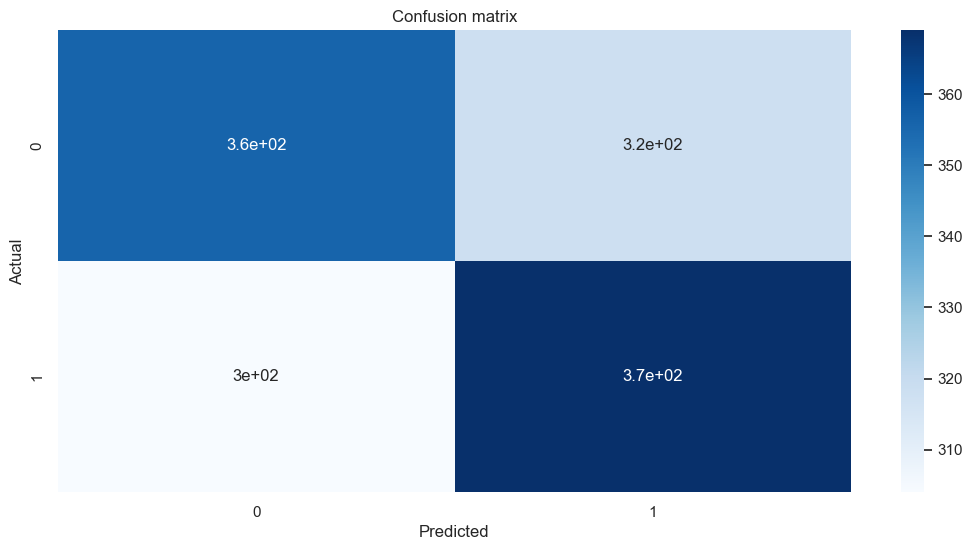

mnbc_csp4
Results for pipeline with mnbc_csp4:
----------------
Test accuracy scores: 0.5159613956941351
----------------
train accuracy scores: 0.5439210693825589

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.4771    0.6039    0.5331       674
           1     0.4595    0.3373    0.3890       673

    accuracy                         0.4707      1347
   macro avg     0.4683    0.4706    0.4611      1347
weighted avg     0.4683    0.4707    0.4611      1347



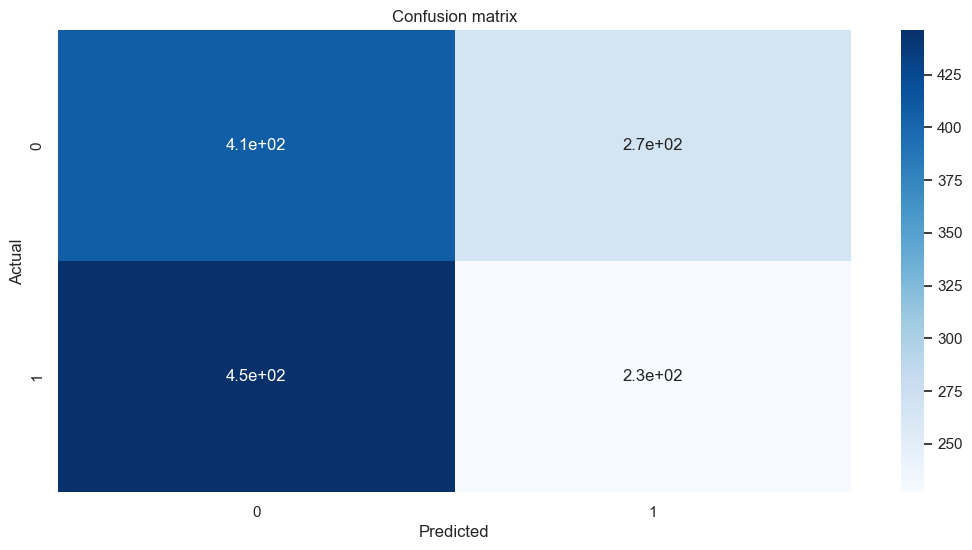

mnbc_csp15
Results for pipeline with mnbc_csp15:
----------------
Test accuracy scores: 0.5159613956941351
----------------
train accuracy scores: 0.5439210693825589

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.4430    0.4955    0.4678       674
           1     0.4266    0.3759    0.3997       673

    accuracy                         0.4358      1347
   macro avg     0.4348    0.4357    0.4337      1347
weighted avg     0.4348    0.4358    0.4338      1347



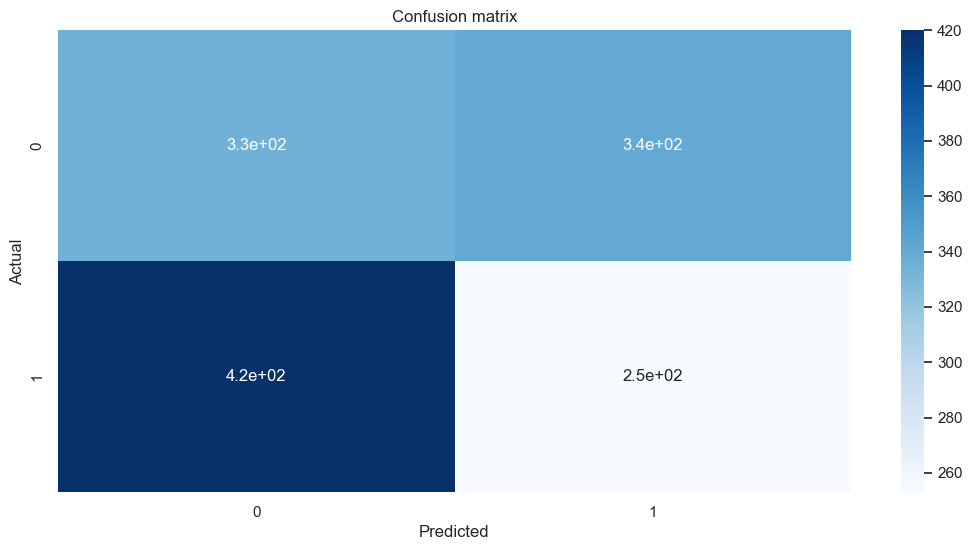

mnbc_pca12_channel
Results for pipeline with mnbc_pca12_channel:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------


c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



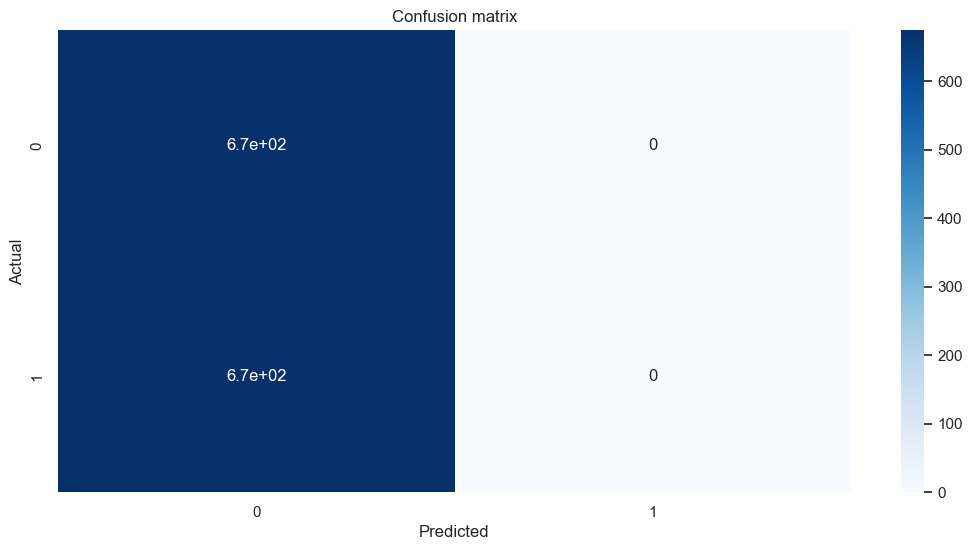

mnbc_pca16_data
Results for pipeline with mnbc_pca16_data:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


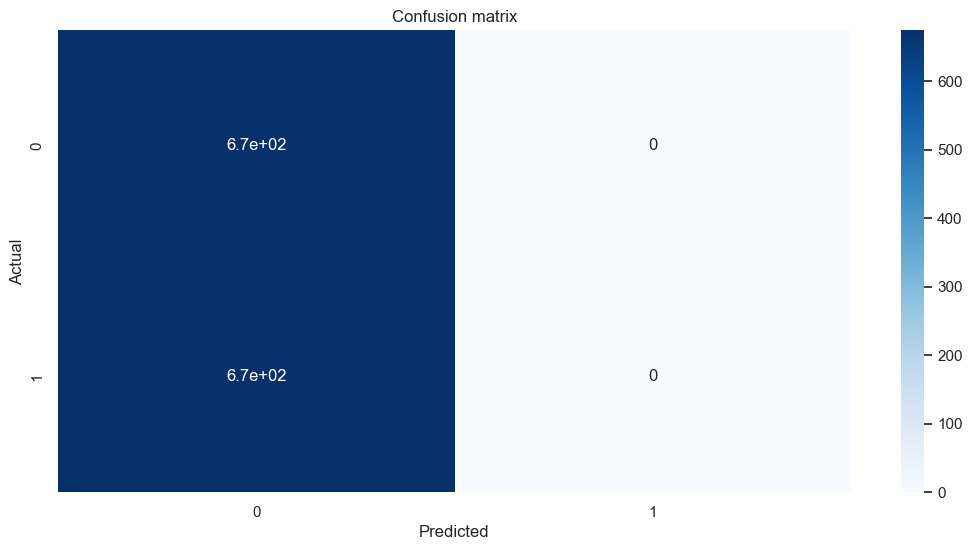

mnbc_pca900_all
Results for pipeline with mnbc_pca900_all:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


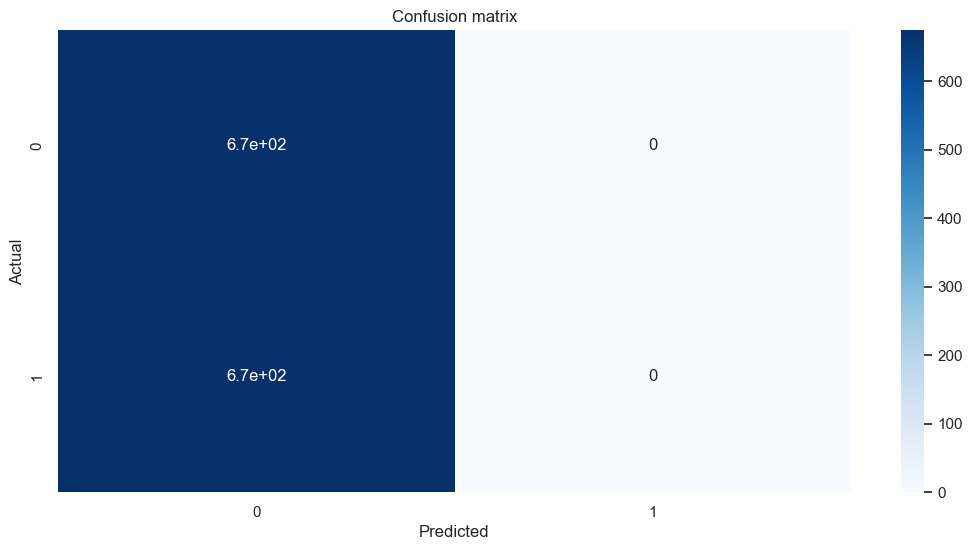

mnbc_pca12_channel_csp4
Results for pipeline with mnbc_pca12_channel_csp4:
----------------
Test accuracy scores: 0.5508537490720119
----------------
train accuracy scores: 0.5534691279439847

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.4516    0.5890    0.5113       674
           1     0.4081    0.2838    0.3348       673

    accuracy                         0.4365      1347
   macro avg     0.4299    0.4364    0.4230      1347
weighted avg     0.4299    0.4365    0.4231      1347



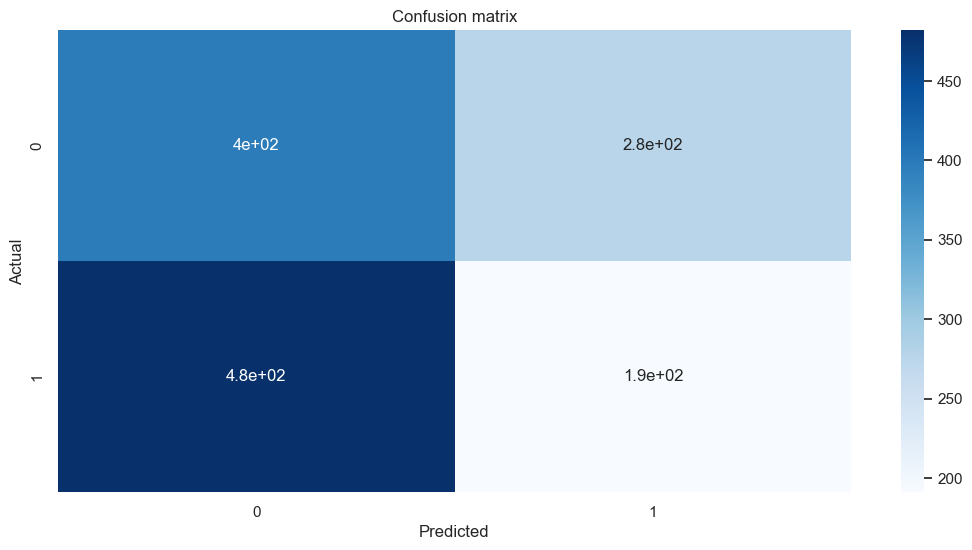

mnbc_pca16_data_csp4
Results for pipeline with mnbc_pca16_data_csp4:
----------------
Test accuracy scores: 0.5174461766889383
----------------
train accuracy scores: 0.5579248886059834

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.4846    0.6306    0.5480       674
           1     0.4702    0.3284    0.3867       673

    accuracy                         0.4796      1347
   macro avg     0.4774    0.4795    0.4674      1347
weighted avg     0.4774    0.4796    0.4674      1347



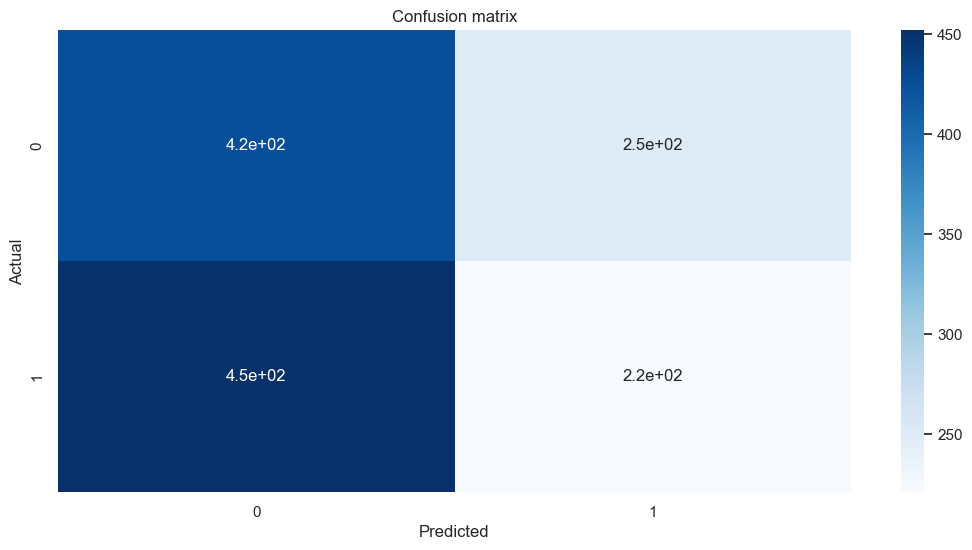

mnbc_pca12_channel_csp15
Results for pipeline with mnbc_pca12_channel_csp15:
----------------
Test accuracy scores: 0.5293244246473645
----------------
train accuracy scores: 0.5486950986632718

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.4466    0.5712    0.5013       674
           1     0.4041    0.2912    0.3385       673

    accuracy                         0.4313      1347
   macro avg     0.4254    0.4312    0.4199      1347
weighted avg     0.4254    0.4313    0.4200      1347



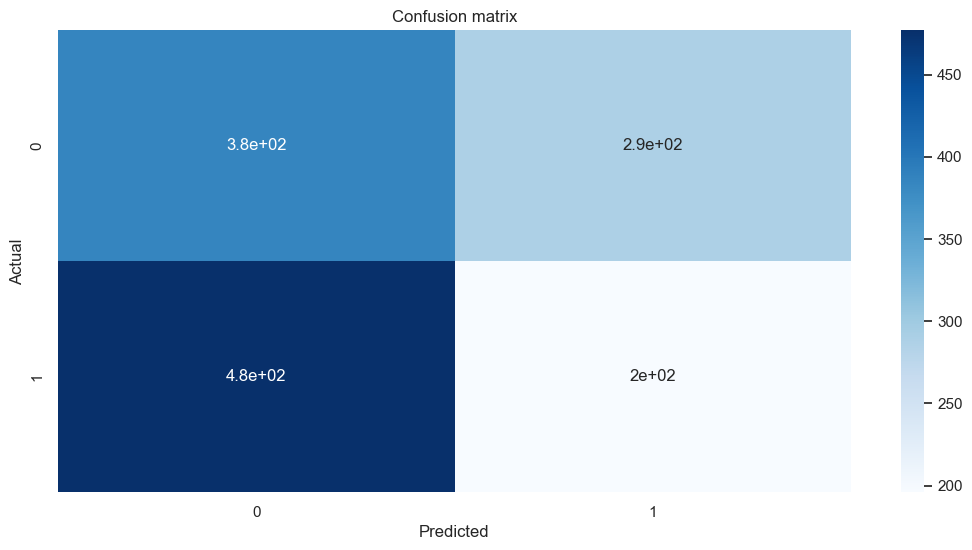

mnbc_pca16_data_csp15
Results for pipeline with mnbc_pca16_data_csp15:
----------------
Test accuracy scores: 0.5219005196733482
----------------
train accuracy scores: 0.5712921705919797

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.4779    0.6098    0.5359       674
           1     0.4600    0.3328    0.3862       673

    accuracy                         0.4714      1347
   macro avg     0.4689    0.4713    0.4610      1347
weighted avg     0.4689    0.4714    0.4611      1347



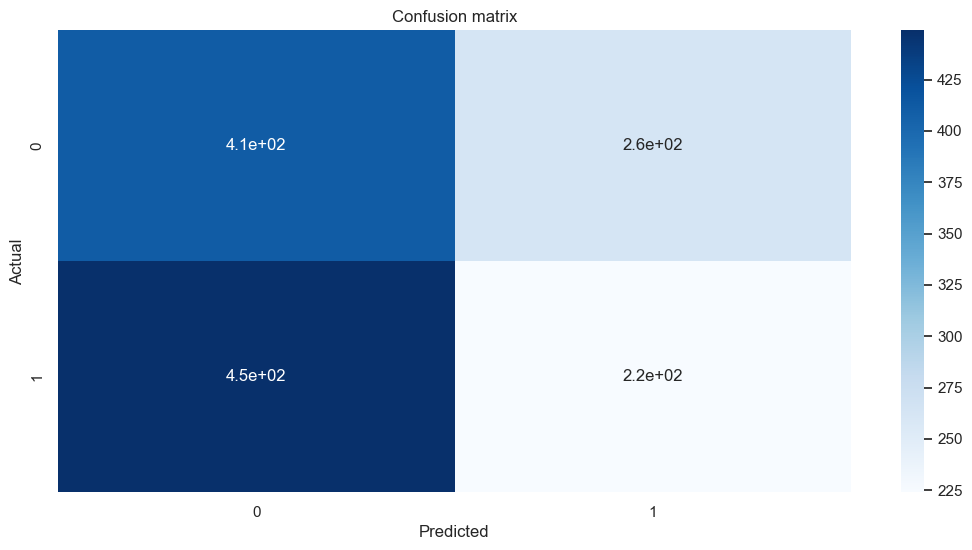

MLP_csp4
Results for pipeline with MLP_csp4:
----------------
Test accuracy scores: 0.49962880475129917
----------------
train accuracy scores: 0.4987269255251432

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       674
           1     0.4996    1.0000    0.6663       673

    accuracy                         0.4996      1347
   macro avg     0.2498    0.5000    0.3332      1347
weighted avg     0.2496    0.4996    0.3329      1347



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


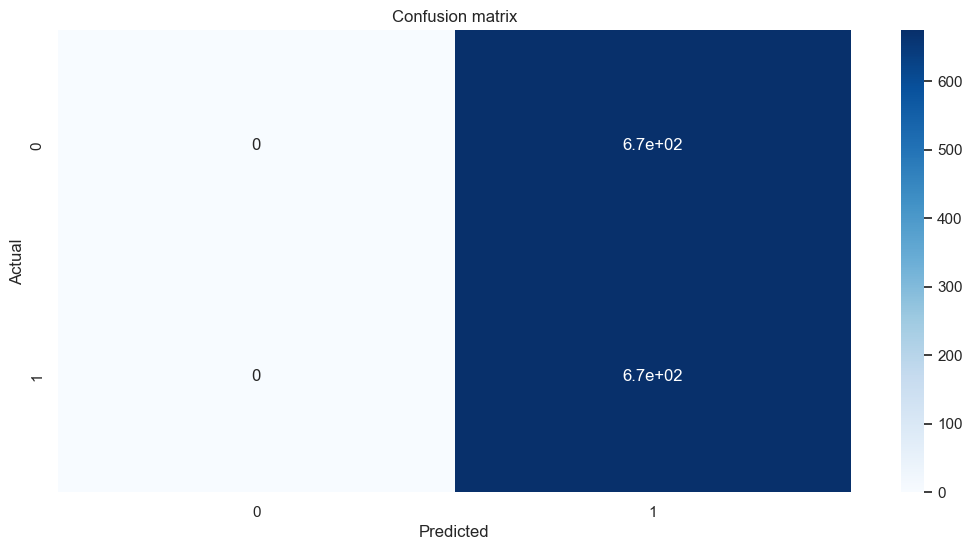

MLP_csp15
Results for pipeline with MLP_csp15:
----------------
Test accuracy scores: 0.49962880475129917
----------------
train accuracy scores: 0.4987269255251432

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       674
           1     0.4996    1.0000    0.6663       673

    accuracy                         0.4996      1347
   macro avg     0.2498    0.5000    0.3332      1347
weighted avg     0.2496    0.4996    0.3329      1347



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


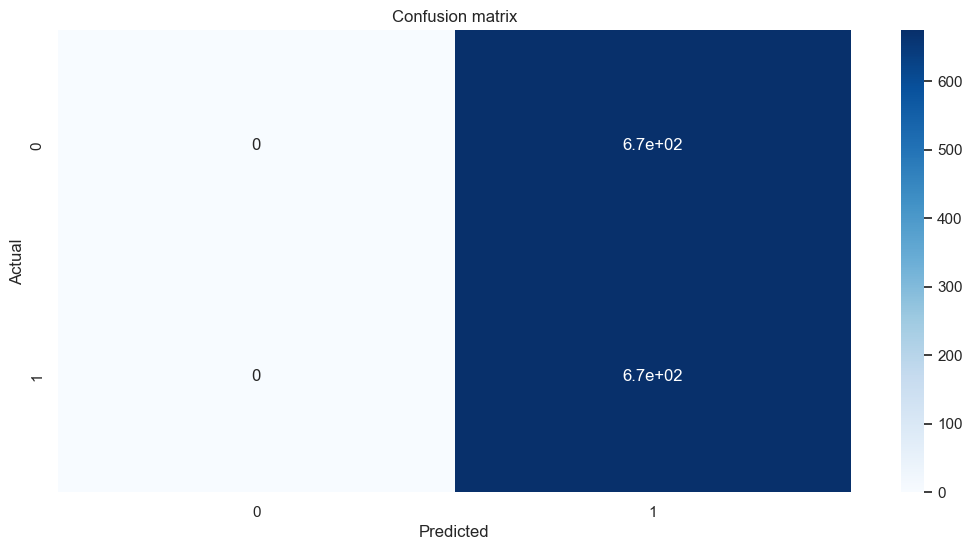

MLP_pca12_channel
Results for pipeline with MLP_pca12_channel:
----------------
Test accuracy scores: 0.5159613956941351
----------------
train accuracy scores: 0.972310630171865

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5166    0.5089    0.5127       674
           1     0.5154    0.5230    0.5192       673

    accuracy                         0.5160      1347
   macro avg     0.5160    0.5160    0.5159      1347
weighted avg     0.5160    0.5160    0.5159      1347



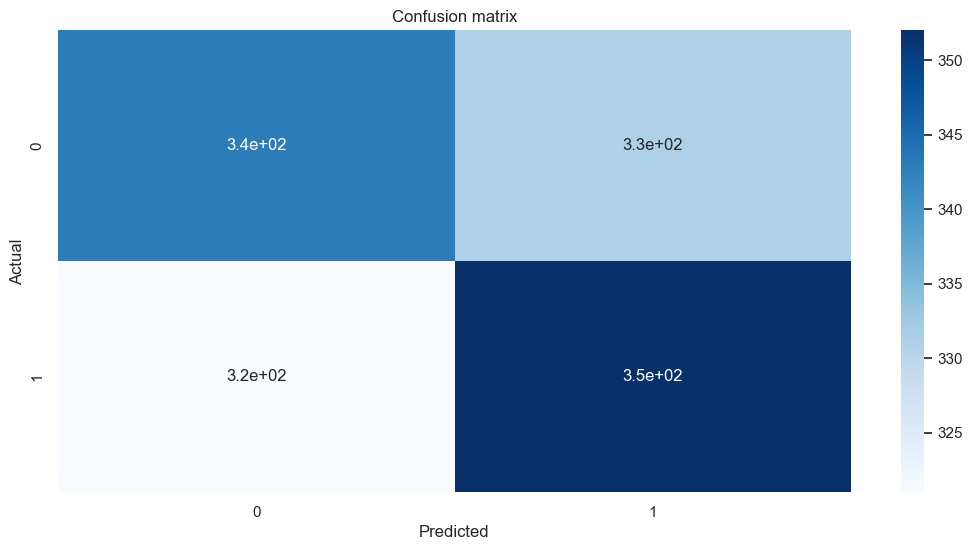

MLP_pca16_data
Results for pipeline with MLP_pca16_data:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


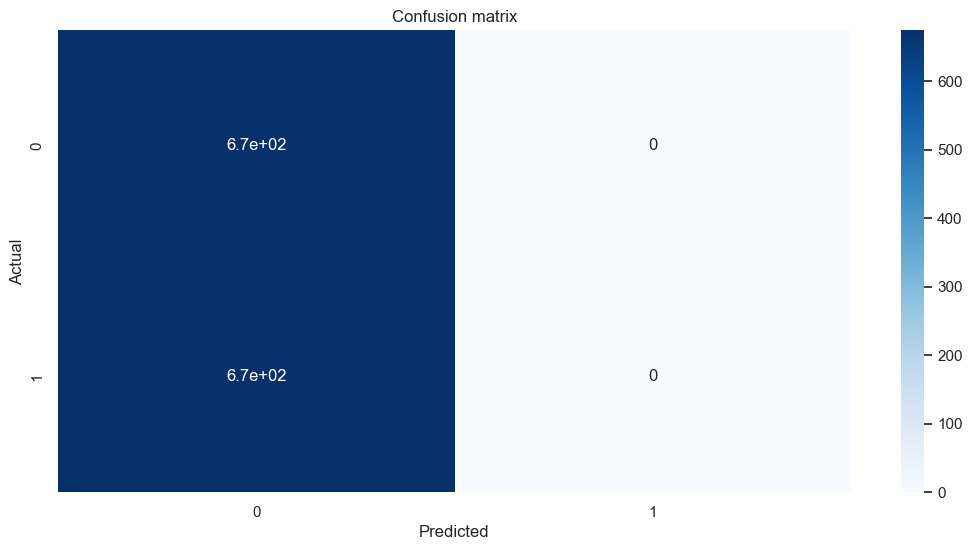

MLP_pca900_all
Results for pipeline with MLP_pca900_all:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


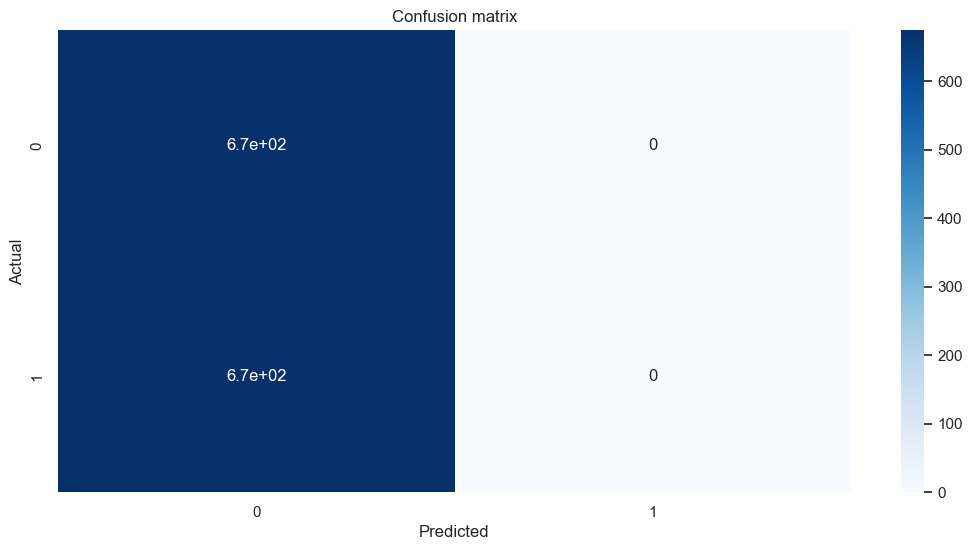

MLP_pca12_channel_csp4
Results for pipeline with MLP_pca12_channel_csp4:
----------------
Test accuracy scores: 0.49962880475129917
----------------
train accuracy scores: 0.4987269255251432

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       674
           1     0.4996    1.0000    0.6663       673

    accuracy                         0.4996      1347
   macro avg     0.2498    0.5000    0.3332      1347
weighted avg     0.2496    0.4996    0.3329      1347



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


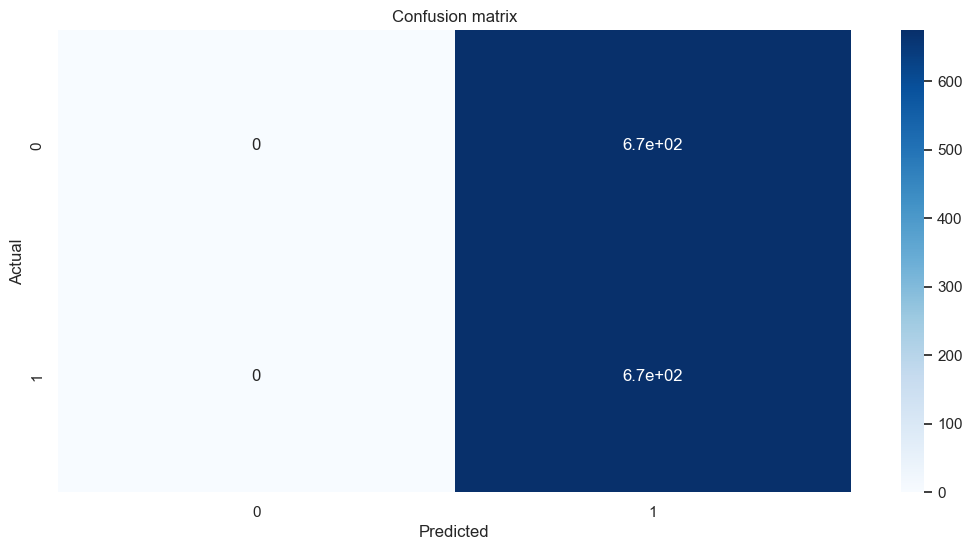

MLP_pca16_data_csp4
Results for pipeline with MLP_pca16_data_csp4:
----------------
Test accuracy scores: 0.5256124721603563
----------------
train accuracy scores: 0.7406110757479313

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5250    0.5460    0.5353       674
           1     0.5263    0.5052    0.5155       673

    accuracy                         0.5256      1347
   macro avg     0.5256    0.5256    0.5254      1347
weighted avg     0.5256    0.5256    0.5254      1347



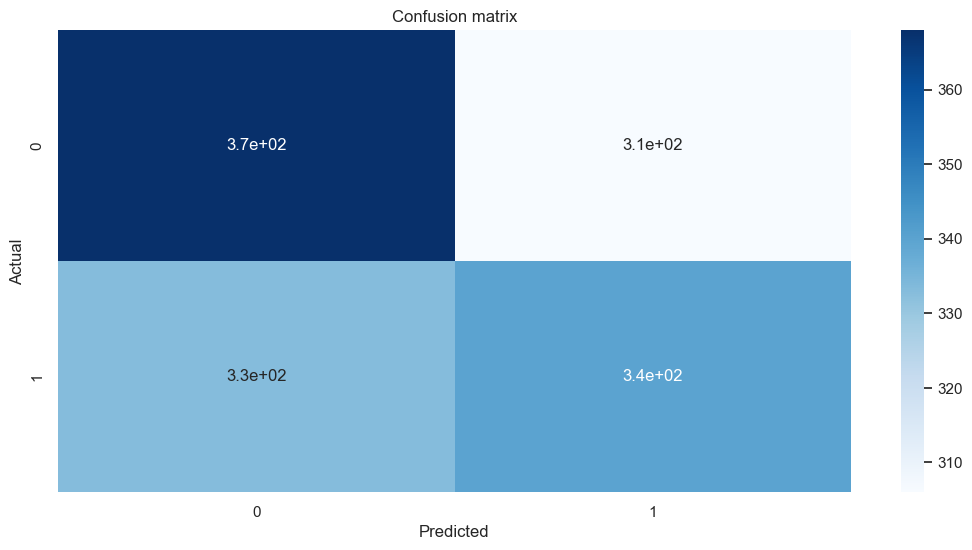

MLP_pca12_channel_csp15
Results for pipeline with MLP_pca12_channel_csp15:
----------------
Test accuracy scores: 0.5664439495174461
----------------
train accuracy scores: 0.8109484404837684

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5571    0.6513    0.6005       674
           1     0.5796    0.4814    0.5260       673

    accuracy                         0.5664      1347
   macro avg     0.5684    0.5664    0.5633      1347
weighted avg     0.5683    0.5664    0.5633      1347



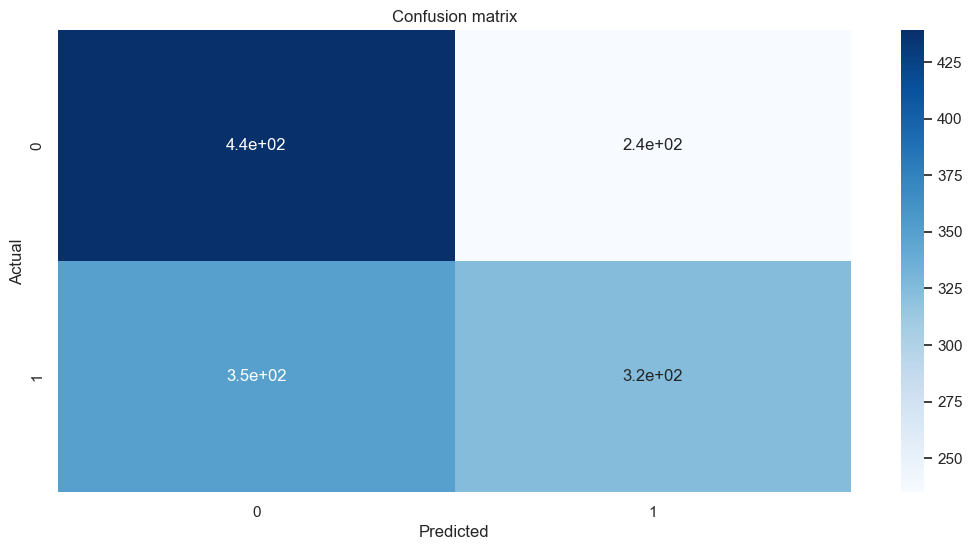

MLP_pca16_data_csp15
Results for pipeline with MLP_pca16_data_csp15:
----------------
Test accuracy scores: 0.5226429101707498
----------------
train accuracy scores: 0.9143857415658816

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5281    0.4318    0.4751       674
           1     0.5188    0.6137    0.5623       673

    accuracy                         0.5226      1347
   macro avg     0.5235    0.5227    0.5187      1347
weighted avg     0.5235    0.5226    0.5187      1347



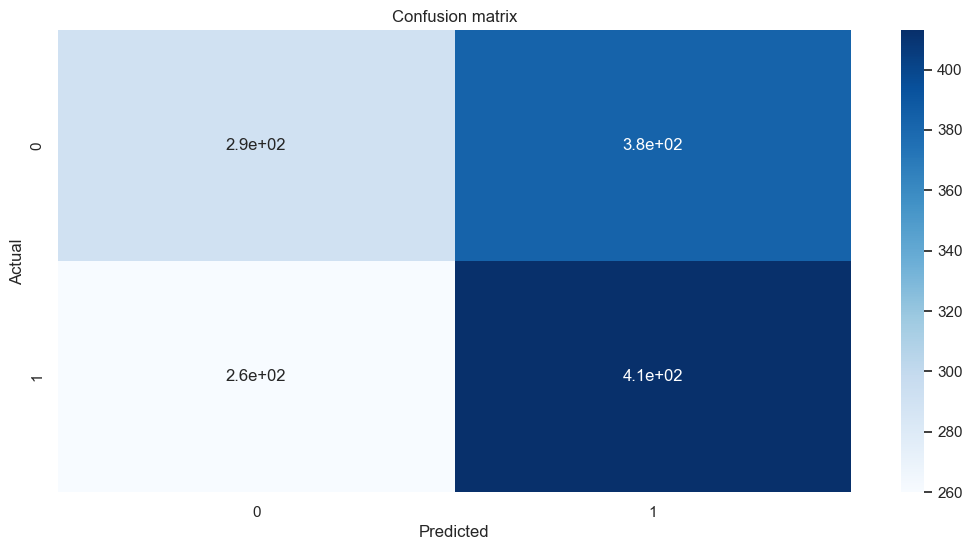

Keras_MLP_csp4
Results for pipeline with Keras_MLP_csp4:
----------------
Test accuracy scores: 0.5300668151447662
----------------
train accuracy scores: 0.5687460216422661

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5200    0.7893    0.6270       674
           1     0.5617    0.2704    0.3651       673

    accuracy                         0.5301      1347
   macro avg     0.5409    0.5299    0.4960      1347
weighted avg     0.5409    0.5301    0.4961      1347



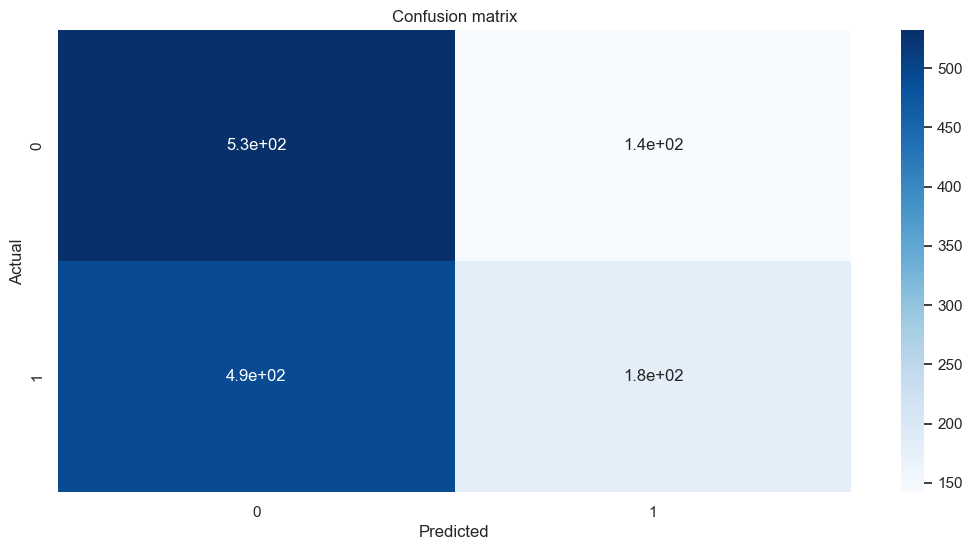

Keras_MLP_csp15
Results for pipeline with Keras_MLP_csp15:
----------------
Test accuracy scores: 0.5515961395694136
----------------
train accuracy scores: 0.6260343730108211

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5448    0.6320    0.5852       674
           1     0.5611    0.4710    0.5121       673

    accuracy                         0.5516      1347
   macro avg     0.5529    0.5515    0.5486      1347
weighted avg     0.5529    0.5516    0.5487      1347



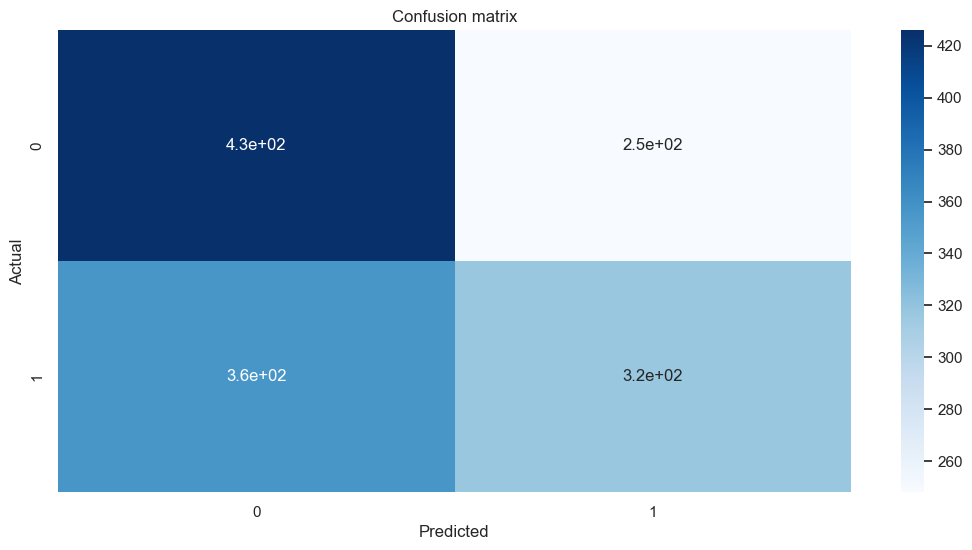

Keras_MLP_pca12_channel
Results for pipeline with Keras_MLP_pca12_channel:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


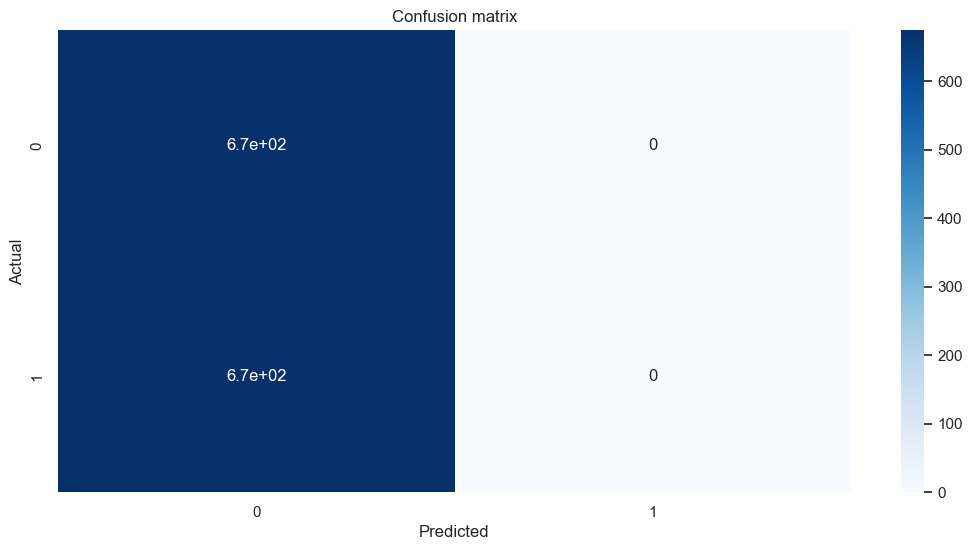

Keras_MLP_pca16_data
Results for pipeline with Keras_MLP_pca16_data:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


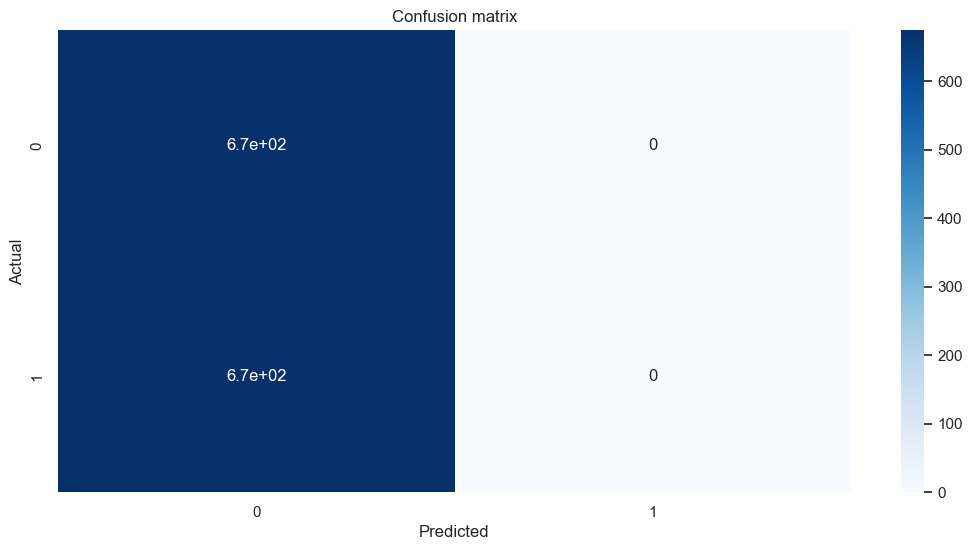

Keras_MLP_pca900_all
Results for pipeline with Keras_MLP_pca900_all:
----------------
Test accuracy scores: 0.5003711952487008
----------------
train accuracy scores: 0.5012730744748568

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5004    1.0000    0.6670       674
           1     0.0000    0.0000    0.0000       673

    accuracy                         0.5004      1347
   macro avg     0.2502    0.5000    0.3335      1347
weighted avg     0.2504    0.5004    0.3337      1347



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


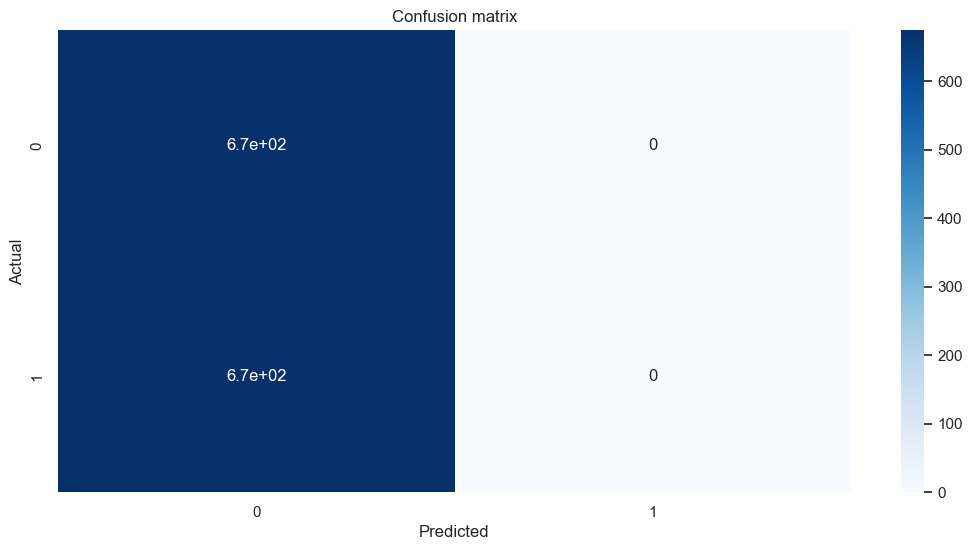

Keras_MLP_pca16_data_csp4
Results for pipeline with Keras_MLP_pca16_data_csp4:
----------------
Test accuracy scores: 0.5315515961395694
----------------
train accuracy scores: 0.583386378103119

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5319    0.5326    0.5322       674
           1     0.5312    0.5305    0.5309       673

    accuracy                         0.5316      1347
   macro avg     0.5316    0.5316    0.5316      1347
weighted avg     0.5316    0.5316    0.5316      1347



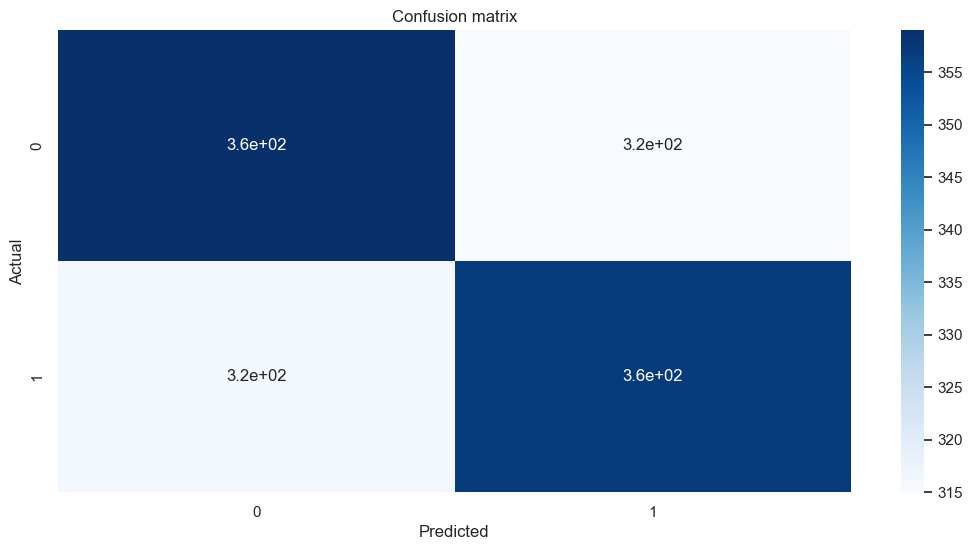

Keras_MLP_pca12_channel_csp4
Results for pipeline with Keras_MLP_pca12_channel_csp4:
----------------
Test accuracy scores: 0.5820341499628805
----------------
train accuracy scores: 0.5929344366645449

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5759    0.6246    0.5993       674
           1     0.5893    0.5394    0.5632       673

    accuracy                         0.5820      1347
   macro avg     0.5826    0.5820    0.5813      1347
weighted avg     0.5826    0.5820    0.5813      1347



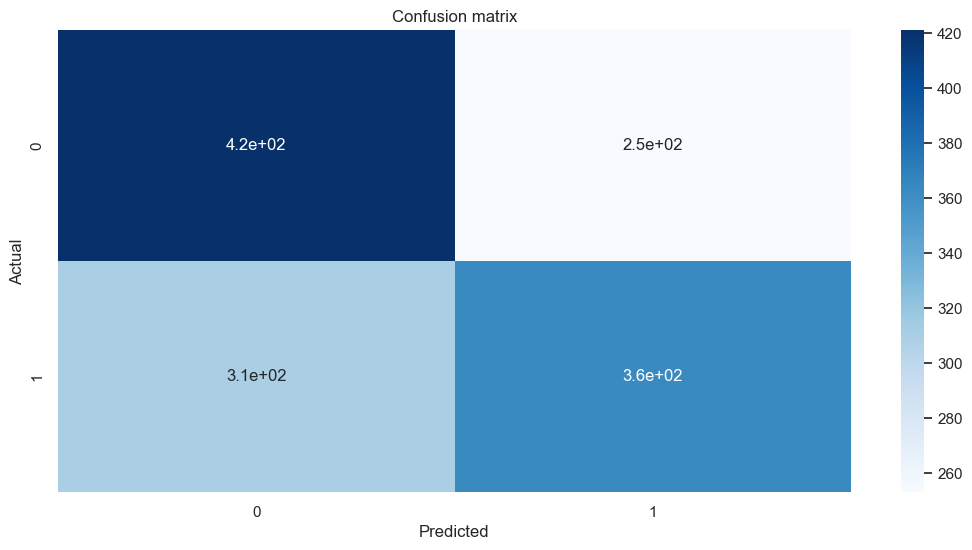

Keras_MLP_pca16_data_csp15
Results for pipeline with Keras_MLP_pca16_data_csp15:
----------------
Test accuracy scores: 0.5270972531551597
----------------
train accuracy scores: 0.645448758752387

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5310    0.4703    0.4988       674
           1     0.5240    0.5840    0.5524       673

    accuracy                         0.5271      1347
   macro avg     0.5275    0.5271    0.5256      1347
weighted avg     0.5275    0.5271    0.5256      1347



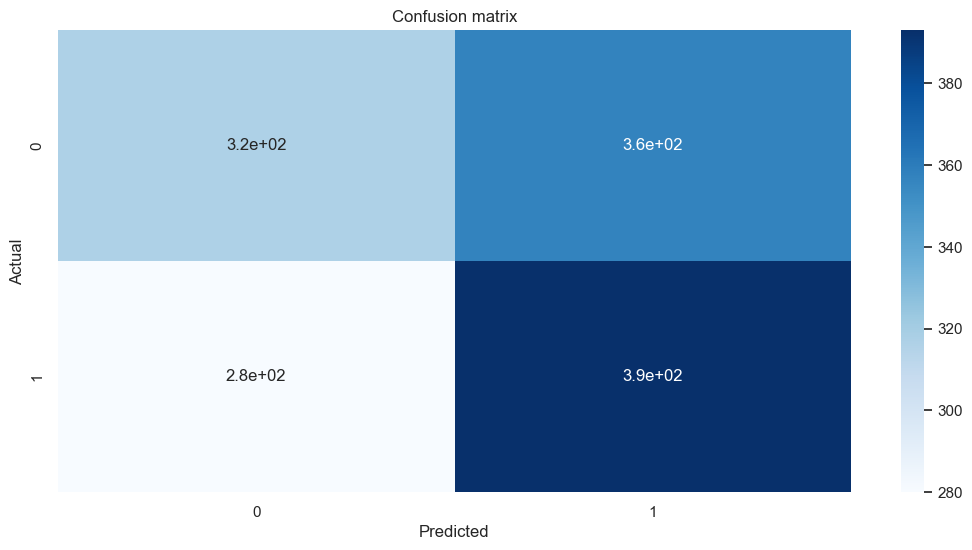

Keras_MLP_pca12_channel_csp15
Results for pipeline with Keras_MLP_pca12_channel_csp15:
----------------
Test accuracy scores: 0.5679287305122495
----------------
train accuracy scores: 0.5862507956715468

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5652    0.5920    0.5783       674
           1     0.5710    0.5438    0.5571       673

    accuracy                         0.5679      1347
   macro avg     0.5681    0.5679    0.5677      1347
weighted avg     0.5681    0.5679    0.5677      1347



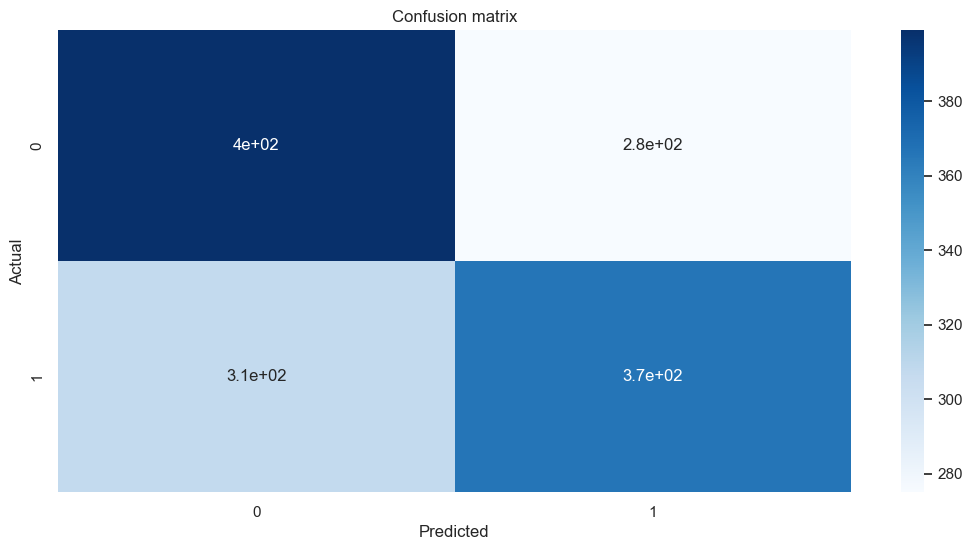

In [339]:
results_val = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    pipeline.fit( pipe.processed_X_train, y_train)
    train_score = pipeline.score(pipe.processed_X_train,y_train)
    val_score = pipeline.score(pipe.processed_X_val,y_val)


    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", val_score)
    print("----------------")
    print("train accuracy scores:", train_score)
    print()
    print("--------------------------------------------------------------------------------------------")

    results_val[pipe.name] = (pipeline)
    f1,acc = display_results(pd.DataFrame(y_val)[0],pipe.model.predict(pipe.processed_X_val))


In [340]:
len(y_val)

1347

In [341]:
np.sum(y_val)

673

In [342]:
1347-673

674

In [343]:
674/1347


0.5003711952487008

In [344]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [345]:
pipe.processed_X_val[:, n : (n + w_length)]

array([], shape=(1347, 0), dtype=float64)

In [346]:
results_val["lda_pca12_channel_csp4"]

Pipeline(steps=[('model', LinearDiscriminantAnalysis())])

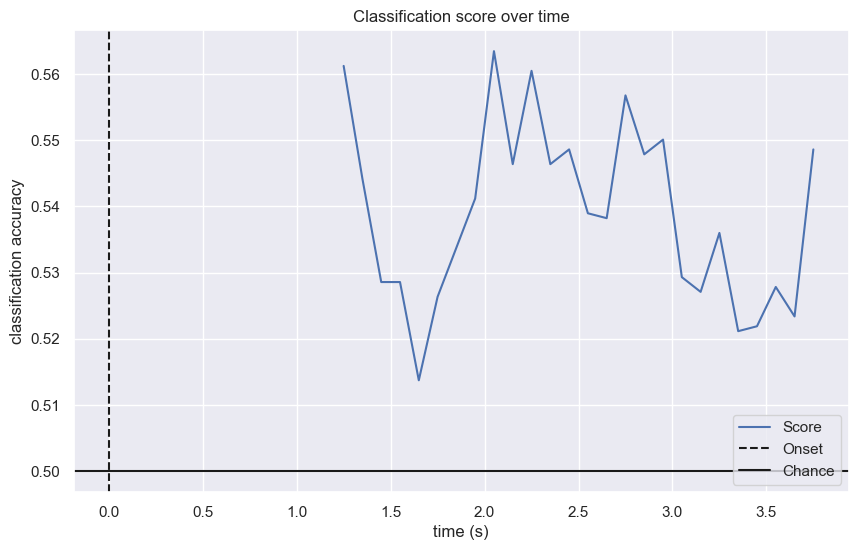

In [347]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_train.shape[2] - w_length, w_step)

scores_windows = []


# running classifier: test classifier on sliding window
score_this_window = []
for n in w_start:
    transform_list = []
    for event in X_val[:, :, n : (n + w_length)]:
        transform_list.append(pca12_channel.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    X_val_windoed_csp15 = pca12_channel_csp15.transform(transform_list.T)
    score_this_window.append(results_val["lda_pca12_channel_csp15"].score(X_val_windoed_csp15, y_val))
scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs_train.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()